In [ ]:
from IPython.display import display, HTML 
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List

from phik import phik_matrix

from scipy.stats import ttest_ind
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer 
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках
%matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.2f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

# **Описание проекта**

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. Собрав определенные данные путем опроса, заказчик поставил две задачи:


* **Задача 1:** **модель предскажет уровень удовлетворённости сотрудника**

    По результатам опроса рассчитана доля удовлетворённости сотрудника от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
    

* **Задача 2:** **модель предскажет, что сотрудник уволится из компании.**

    Удовлетворённость работой напрямую влияет на отток сотрудников. Предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

# **ЗАДАЧА I: предсказать уровень удовлетворённости сотрудника** 

## **Описание признаков**

Признаки одинаковые для двух задач:

* **id** — уникальный идентификатор сотрудника;
* **dept** — отдел, в котором работает сотрудник;
* **level** — уровень занимаемой должности;
* **workload** — уровень загруженности сотрудника;
* **employment_years** — длительность работы в компании (в годах);
* **last_year_promo** — показывает, было ли повышение за последний год;
* **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
* **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
* **salary** — ежемесячная зарплата сотрудника;
* **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.

# **Шаг I-1. Загрузка данных**


* **Тренировочная выборка:**
train_job_satisfaction_rate.csv
* **Входные признаки тестовой выборки:**
test_features.csv
* **Целевой признак тестовой выборки:**
test_target_job_satisfaction_rate.csv

In [276]:
try:
    train_job_satisfaction_rate_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/train_job_satisfaction_rate.csv')
    test_features_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/test_features.csv')
    test_target_job_satisfaction_rate_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/test_target_job_satisfaction_rate.csv')
except:
    train_job_satisfaction_rate_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
    test_features_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    test_target_job_satisfaction_rate_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [277]:
df_dict = {
            'train_job_satisfaction_rate_df': train_job_satisfaction_rate_df, 
            'test_features_df': test_features_df, 
            'test_target_job_satisfaction_rate_df': test_target_job_satisfaction_rate_df
            }

# **Шаг I-2. Предобработка данных**

## **2.1. Изучим данные**


Изучим данные и сделаем выводы. При необходимости выполним предобработку.

In [278]:
for name, df in df_dict.items():
    print(f'======={name}==========================')
    print(f'Данные {name} имеют следующие признаки:\n')
    display(df.head(10))
    df.info()

=======train_job_satisfaction_rate_df==========================
Данные train_job_satisfaction_rate_df имеют следующие признаки:



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
=======test_features_df==========================
Данные test_features_df имеют следующие признаки:



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
=======test_target_job_satisfaction_rate_df==========================
Данные test_target_job_satisfaction_rate_df имеют следующие признаки:



,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


**Что сдедует устранить:**

1) есть пропуски в полях `dept` И `level` в датафреймах `train_job_satisfaction_rate_df` и `test_features_df`.
2) в `test_features_df` - два пропуска в одной колонке и один пропуск в другой колонке = 3 - несовпадение с `y_test` = `test_target_job_satisfaction_rate_df`

Других проблем пока выявить не удалось.
Типы данных соответсвуют, названия колонок нормальные.

## **2.2. Предварительная проверка на общие id**

Чтобы синхронно обработать все строки во всех датафреймах и чтобы их размерность совпала - нужно тогда объединить эти таблицы и разъединить обратно.

Перед предобработкой проверим одинковые айди в y_test и y_train

In [279]:
# Проверим общие id
print("Размеры до синхронизации:")
print(f"test_features_df: {len(test_features_df)}")
print(f"test_target_df: {len(test_target_job_satisfaction_rate_df)}")

# Найдите общие id
common_ids = set(test_features_df['id']) & set(test_target_job_satisfaction_rate_df['id'])
print(f"Общих id: {len(common_ids)}")

Размеры до синхронизации:
test_features_df: 2000
test_target_df: 2000
Общих id: 2000


## **2.3. Объединение таблиц для предобработки**

In [280]:
# 1. ОБЪЕДИНЯЕМ тестовые данные
test_combined_df = test_features_df.merge(test_target_job_satisfaction_rate_df, on='id', how='inner')

# 2. ВРЕМЕННО меняем словарь датафреймов (только для обработки)
temp_df_dict = {
    'train_job_satisfaction_rate_df': train_job_satisfaction_rate_df, 
    'test_combined_df': test_combined_df  # ОДИН объединенный test датафрейм
}

**Решение:**
* удалим строки с пропущенными значениями. 
* Проверим заодно наличие запятой в дробной части вместо точки и удалим;
* Проверим на выбросы и удалим;
* Проверим на неявные дубликаты - выведем список;
* Проверим на явные дубликаты - удалим.
Просили делать это через пайплайн.

## **2.4. Создание пайплайна для предобработки**

In [281]:
class DecimalPointChanger(BaseEstimator, TransformerMixin):
    """Класс для замены разделителя дроби в строковых столбцах"""

    def __init__(self, columns=None):
        """Инициализация заменщика дроби в строковых столбцах"""
        self.columns = columns  # список столбцов, в которых нужно заменить разделитель дроби
    
    def fit_transform(self, df, y=None):
        """Непосредственно заменяет разделитель дроби запятую на точку"""
        print('- Определяю необходимость замены запятой на точку')
        
        # Если columns не указаны, обрабатываем все столбцы
        cols_to_process = self.columns if self.columns else df.columns
        
        for col in cols_to_process:
            if col in df.columns:
                # Проверяем, есть ли запятые в столбце
                if df[col].dtype == 'object' and df[col].str.contains(',').any():
                    df[col] = df[col].str.replace(',', '.').astype(float)
                    print(f'- Заменил запятую на точку в столбце {col}')
                    print(f'--- Значения в столбце {col}: {df[col].unique()}\n')
                else:
                    print(f'- В столбце {col} замена разделителя не требуется')
        
        print('- Обработка завершена\n')
        return df

In [282]:
class OutlierRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления выбросов из данных методом IQR только для train"""

    def __init__(self, columns=None, factor=1.5):
        """Инициализация удалителя выбросов. Есть возможность указать столбцы, в которых убирать выбросы. По умолчанию размер услов 1.5 квартиля"""
        self.columns = columns
        self.factor = factor
        self.bounds_dict = {}  # для хранения границ выбросов


    def fit_transform(self, df, name=None, y=None):
        """Обучает удалитель выбросов - описывает размер квантилей и границы усов. Удаляет выбросы"""

        if 'test' in name:
            print(f'- Удаление выбросов не проводится в тестовой выборке {name}, пропускаю шаг.')
            return df

        print('- Определяю границы выбросов методом IQR')
        
        df_transformed = df.copy()

        
        cols_to_process = self.columns if self.columns else df_transformed.select_dtypes(include=[np.number]).columns
        
        # Проверка на наличие выбросов
        outlier_cols = []
        for col in cols_to_process:
            if col in df_transformed.columns:
                Q1 = df_transformed[col].quantile(0.25)
                Q3 = df_transformed[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.factor * IQR
                upper_bound = Q3 + self.factor * IQR
                self.bounds_dict[col] = (lower_bound, upper_bound)
                
                outliers = (df_transformed[col] < lower_bound) | (df_transformed[col] > upper_bound)
                if outliers.any():
                    outlier_cols.append(col)
        
        if not outlier_cols:
            print('- Выбросы не обнаружены')
            return df_transformed
        
        print(f'- Обнаружены выбросы в столбцах: {outlier_cols}')
        
        # Показ боксплотов для столбцов с выбросами
        n_cols = len(outlier_cols)
        fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 4))
        if n_cols == 1:
            axes = [axes]
        
        for i, col in enumerate(outlier_cols):
            lower_bound, upper_bound = self.bounds_dict[col]
            print(f'Нормальные пределы для {col}: [{lower_bound:.2f} - {upper_bound:.2f}]')
            sns.boxplot(y=df_transformed[col], ax=axes[i])
            axes[i].set_title(f'Выбросы в {col}')
        
        plt.tight_layout()
        plt.show()
        
        # Удаление выбросов
        print('- Выполняю удаление выбросов\n')
        for col, (lower_bound, upper_bound) in self.bounds_dict.items():
            if col in df_transformed.columns:
                outliers = (df_transformed[col] < lower_bound) | (df_transformed[col] > upper_bound)
                df_transformed = df_transformed[~outliers]
                
        return df_transformed

In [283]:
class ImplicitDuplicatesViewer(BaseEstimator, TransformerMixin):
    """Выводит уникальные значения каждого столбца для визуального определения неявных дубликатов"""

    def __init__(self, columns=None):
        """Инициализация определеителя неявных дуликатов"""
        self.columns = columns


    def fit(self, df, y=None):
        return self


    def transform(self, df, y=None):
        """Выводит уникальные значения каждого столбца для визуального определения неявных дуликатов"""

        print('- Выполняю поиск неявных дубликатов в нечисловых столбцах\n')

        if self.columns:
            for col in self.columns:
                if col in df.columns:
                    print(f'- Уникальные значения в столбце {col}: {df[col].unique()}\n')
            return df
        else: 
            columns = df.select_dtypes(exclude=[np.number]).columns
            for col in columns:
                print(f'- Уникальные значения в столбце {col}: {df[col].unique()}\n')
            return df
        
    def fit_transform(self, df, y=None):
        return self.fit(df, y).transform(df)

In [284]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления дубликатов"""

    def __init__(self, columns=None):
        """Инициализация удалителя дубликатов"""
        self.columns = columns

    def fit(self, df, y=None):
        return self

    def transform(self, df, y=None):
        """Удаляет дубликаты"""

        duplicate_count = df.duplicated().sum()

        if duplicate_count:
            print(f'- Выявлено {duplicate_count} дубликатов')
            print('- Выполняю удаление дубликатов\n')

            if self.columns:
                df = df.drop_duplicates(subset=self.columns)                
            else:
                df = df.drop_duplicates()
            
            remaining_duplicates = df.duplicated().sum()
            print(f'- Осталось {remaining_duplicates} дубликатов\n')

        else:
            print('- Дубликатов не выявлено\n')


        return df
            
    
    def fit_transform(self, df, y=None):
        return self.fit(df, y).transform(df)

In [285]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """Класс для обработки пропущенных значений в данных."""

    def __init__(self, strategy='mean', fill_value=None):
        """Инициализация обработчика пропущенных значений. По умолчанию заполняет средним значением.
        """
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}  # для хранения значений для заполнения

    def fit_transform(self, df, y=None):
        """Заполняет пропущенные значения или удаляет строки в тестовой выборке. режимы: mean, median, mode, drop"""
        if self.strategy == 'mean':
            self.fill_values_ = df.select_dtypes(include=[np.number]).mean().to_dict() # словарь средних значений для каждого числового столбца

        elif self.strategy == 'median':
            self.fill_values_ = df.select_dtypes(include=[np.number]).median().to_dict()

        elif self.strategy == 'mode':
            self.fill_values_ = {}
            for col in df.columns:
                self.fill_values_[col] = df[col].value_counts().index[0]

        elif self.strategy == 'drop':
            if df.isna().sum().sum() > 0 or df.eq(" ").any().any():
                print('- Нашел пропуски в данных\n')
                display(df[df.isna().any(axis=1)])
                display(df[df.eq(" ").any(axis=1)])
                print('- Выполняю удаление этих строк с пропущенными значениями\n')
                df = df.dropna()
                df = df[~df.eq(" ").any(axis=1)]  # удаляет пустые пробелы типа пропуск
                if df.isna().sum().sum() == 0:
                    print('- Пропусков не осталось.\n')
                else:
                    print(f'- {df.isna().sum().sum()} пропусков осталось.\n')
                return df
            else:
                print('- Пропусков не найдено\n')

        for col, fill_value in self.fill_values_.items():
             if col in df.columns:
                if df[col].isnull().sum() > 0:
                    print(f'- В колонке {col} {df[col].isnull().sum()} пропусков. Заполняю пропуски\n')
                    df[col] = df[col].fillna(fill_value)

        return df

In [286]:
class EDAPreprocessor:
    """
    Основной класс пайплайна для предобработки данных
    """

    def __init__(self):
        self.steps = []  # список шагов предобработки, которые будут выполняться в пайплайне
        self.fitted_transformers = {}  # для хранения обученных трансформеров (запоминает что-то и делает)
        

    def add_decimal_point_changer(self, columns=None, step_name='decimal_point_changer'):
        decimal_point_changer = DecimalPointChanger(columns)
        self.steps.append((step_name, decimal_point_changer))
        return self


    def add_missing_value_handler(self, strategy='drop', fill_value=None, step_name='missing_handler'):
        """Добавляет обработчик пропущенных значений в препроцессор"""
        handler = MissingValueHandler(strategy=strategy, fill_value=fill_value)
        self.steps.append((step_name, handler))
        return self    


    def add_outlier_remover(self, step_name='outlier_remover'):
        '''Добавляет шаг удаления выбросов в препроцессор только для train'''
        outlier_remover = OutlierRemover()
        self.steps.append((step_name, outlier_remover))
        return self
 
    
    def add_drop_duplicates(self, step_name='drop_duplicates'):
        """Добавляет шаг удаления дуликатов"""
        duplicate_remover = DuplicateRemover()
        self.steps.append((step_name, duplicate_remover))
        return self
    

    def add_implicit_duplicates_viewer(self, step_name='implicit_duplicates_viewer'):
        """Добавляет шаг отображения уникальных значений каждого столбца для выявления неявных дуликатов визуально."""
        implict_duplicates_viewer = ImplicitDuplicatesViewer()
        self.steps.append((step_name, implict_duplicates_viewer))
        return self
    

    def add_custom_transformer(self, step_name: str, transformer):
        """Добавляет пользовательский трансформер в пайплан предобраотки"""
        self.steps.append((step_name, transformer))
        return self
    

    def fit_transform(self, df, name=None, y=None):
        """Обучает все трансформеры пайплайна (запоминает единые параметры и условия исполнения - консистентность). Принимает df и целевую переменную опционально."""

        for i, (step_name, transformer) in enumerate(self.steps):
            print(f'Исполнение шага {i+1}: {step_name}')
            df = transformer.fit_transform(df, name)
            self.fitted_transformers[step_name] = transformer
            # df = transformer.transform(df)
        return df

## **2.5. Предобработка данных**

Выявим и исправим замечания.

In [287]:
EDA_Preprocessor_pipeline = (
    EDAPreprocessor()  
    .add_decimal_point_changer()        # проверяет наличие запятой в дробном чисе если найдет заменит на точку
    .add_missing_value_handler()
    .add_drop_duplicates()              # проверяет строки дубликаты
    .add_implicit_duplicates_viewer()   # выводит уникальные значения для определения неявных дуликатов
    .add_outlier_remover()              # удаляет пропуски, тестовую выборку пропустит
)

print('Вот такким у нас получился предобработчки данных.')

print("Шаги в пайплайне:")
for i, (name, step) in enumerate(EDA_Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Вот такким у нас получился предобработчки данных.
Шаги в пайплайне:
1. decimal_point_changer: DecimalPointChanger()

2. missing_handler: MissingValueHandler(strategy='drop')

3. drop_duplicates: DuplicateRemover()

4. implicit_duplicates_viewer: ImplicitDuplicatesViewer()

5. outlier_remover: OutlierRemover()



Исправим выявленные замечания.

 =>  Обработка датафрейма train_job_satisfaction_rate_df
Исполнение шага 1: decimal_point_changer
- Определяю необходимость замены запятой на точку
- В столбце id замена разделителя не требуется
- В столбце dept замена разделителя не требуется
- В столбце level замена разделителя не требуется
- В столбце workload замена разделителя не требуется
- В столбце employment_years замена разделителя не требуется
- В столбце last_year_promo замена разделителя не требуется
- В столбце last_year_violations замена разделителя не требуется
- В столбце supervisor_evaluation замена разделителя не требуется
- В столбце salary замена разделителя не требуется
- В столбце job_satisfaction_rate замена разделителя не требуется
- Обработка завершена

Исполнение шага 2: missing_handler
- Нашел пропуски в данных



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate


- Выполняю удаление этих строк с пропущенными значениями

- Пропусков не осталось.

Исполнение шага 3: drop_duplicates
- Дубликатов не выявлено

Исполнение шага 4: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Уникальные значения в столбце dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing']

- Уникальные значения в столбце level: ['junior' 'middle' 'sinior']

- Уникальные значения в столбце workload: ['medium' 'high' 'low']

- Уникальные значения в столбце last_year_promo: ['no' 'yes']

- Уникальные значения в столбце last_year_violations: ['no' 'yes']

Исполнение шага 5: outlier_remover
- Определяю границы выбросов методом IQR
- Обнаружены выбросы в столбцах: ['supervisor_evaluation', 'salary']
Нормальные пределы для supervisor_evaluation: [1.50 - 5.50]
Нормальные пределы для salary: [-7800.00 - 73800.00]


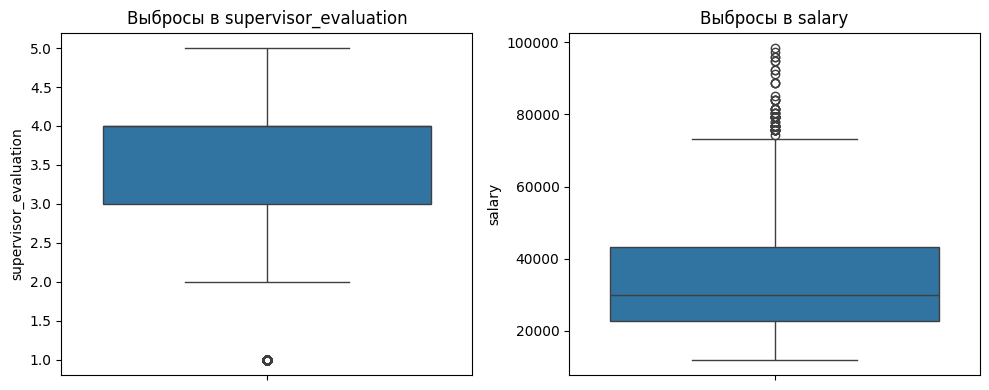

- Выполняю удаление выбросов


Проверка датафрейма train_job_satisfaction_rate_df


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78


 =>  Обработка датафрейма test_combined_df
Исполнение шага 1: decimal_point_changer
- Определяю необходимость замены запятой на точку
- В столбце id замена разделителя не требуется
- В столбце dept замена разделителя не требуется
- В столбце level замена разделителя не требуется
- В столбце workload замена разделителя не требуется
- В столбце employment_years замена разделителя не требуется
- В столбце last_year_promo замена разделителя не требуется
- В столбце last_year_violations замена разделителя не требуется
- В столбце supervisor_evaluation замена разделителя не требуется
- В столбце salary замена разделителя не требуется
- В столбце job_satisfaction_rate замена разделителя не требуется
- Обработка завершена

Исполнение шага 2: missing_handler
- Нашел пропуски в данных



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
191,609865,NaN,junior,medium,1,no,no,1,20400,0.12
312,471990,sales,NaN,low,1,no,no,3,12000,0.17
1196,832342,NaN,junior,medium,1,no,no,4,28800,0.61


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
15,590867,marketing,junior,,4,no,no,4,28800,0.79
1699,822186,,middle,medium,3,no,no,4,38400,0.64


- Выполняю удаление этих строк с пропущенными значениями

- Пропусков не осталось.

Исполнение шага 3: drop_duplicates
- Дубликатов не выявлено

Исполнение шага 4: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology']

- Уникальные значения в столбце level: ['junior' 'middle' 'sinior']

- Уникальные значения в столбце workload: ['medium' 'low' 'high']

- Уникальные значения в столбце last_year_promo: ['no' 'yes']

- Уникальные значения в столбце last_year_violations: ['no' 'yes']

Исполнение шага 5: outlier_remover
- Удаление выбросов не проводится в тестовой выборке test_combined_df, пропускаю шаг.

Проверка датафрейма test_combined_df


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [288]:
def run_preprocessor(temp_df_dict=temp_df_dict):
    """Производит предобработку всех датафреймов в цикле в пайплайне"""
    for name, df in temp_df_dict.items():
        print('=' * 50)
        print(f' =>  Обработка датафрейма {name}')
        print('=' * 50)
        temp_df_dict[name] = EDA_Preprocessor_pipeline.fit_transform(df, name)
        # globals()[name] = df_dict[name]  # Перезаписывает глобальную переменную
        print(f'\nПроверка датафрейма {name}')
        display(temp_df_dict[name].head())

run_preprocessor(temp_df_dict)

In [289]:
# Заменить все пробелы на NaN только в тренировочной выборке
train_job_satisfaction_rate_df = train_job_satisfaction_rate_df.replace(' ', np.nan)
test_combined_df = test_combined_df.replace(' ', np.nan)


В процессе предобработки мы выявили:

1) NaN в столбце `level` и `dept`- не трогаем удалим в шаге 4

2) пустые строки `" "` в столбце `workload` и `dept` - заменили их на `NaN` 

мы их удалим в пайплайне в шаге 4.

2.1) и ошибку в слове `sinior` в столбце `level` исправим на `senior`

исправим это сейчас.

In [290]:
test_combined_df['level'] = test_combined_df['level'].replace('sinior', 'senior')
train_job_satisfaction_rate_df['level'] = train_job_satisfaction_rate_df['level'].replace('sinior', 'senior')

In [291]:
train_job_satisfaction_rate_df['level'].unique()

array(['junior', 'middle', 'senior', nan], dtype=object)

Предобработка закончена, замечания, устранены.

## **2.7. Оценка распределения признаков**

Совместим выборки на совмещенном графике посмотрим распределение признаков.

1. Для дискретных признаков (employment_years, supervisor_evaluation):

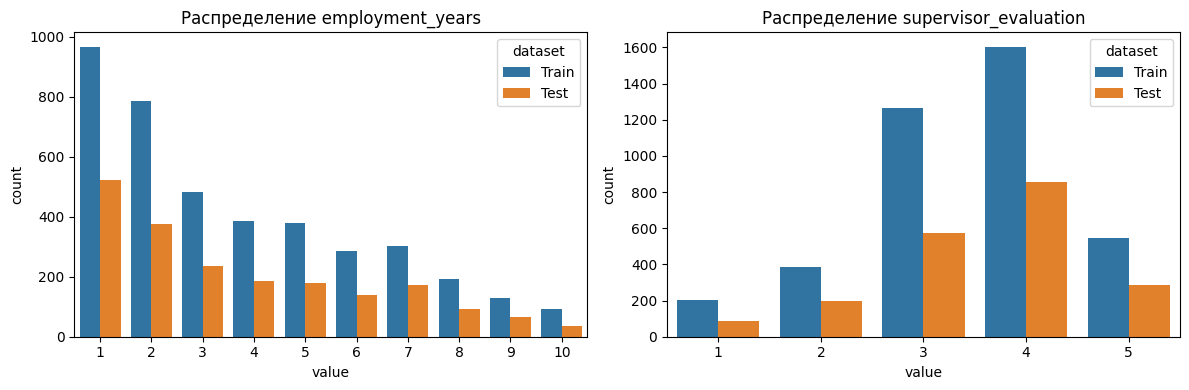

In [292]:
# Дискретные признаки - используем countplot
discrete_cols = ['employment_years', 'supervisor_evaluation']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, col in enumerate(discrete_cols):
    # Объединяем данные для сравнения
    train_data = pd.DataFrame({'value': train_job_satisfaction_rate_df[col], 'dataset': 'Train'})
    test_data = pd.DataFrame({'value': test_combined_df[col], 'dataset': 'Test'})
    combined = pd.concat([train_data, test_data])
    
    sns.countplot(data=combined, x='value', hue='dataset', ax=axes[i])
    axes[i].set_title(f'Распределение {col}')

plt.tight_layout()
plt.show()  

2. Для непрерывных признаков (salary):

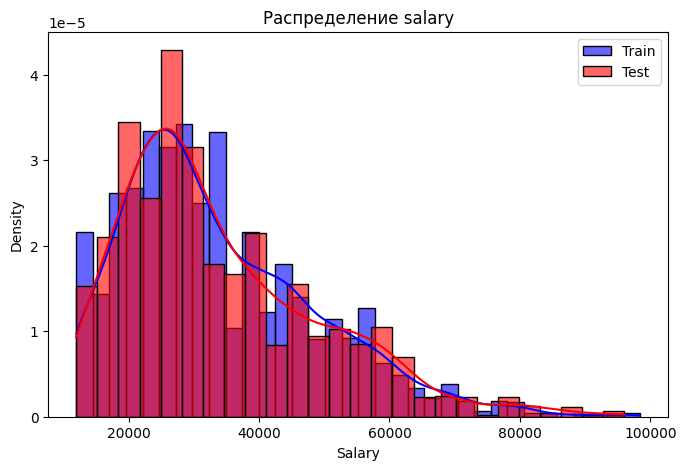

In [293]:
# Непрерывные признаки - нормированные гистограммы
plt.figure(figsize=(8, 5))

sns.histplot(train_job_satisfaction_rate_df['salary'], stat='density', 
             kde=True, alpha=0.6, label='Train', color='blue')
sns.histplot(test_combined_df['salary'], stat='density',
             kde=True, alpha=0.6, label='Test', color='red')

plt.title('Распределение salary')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()


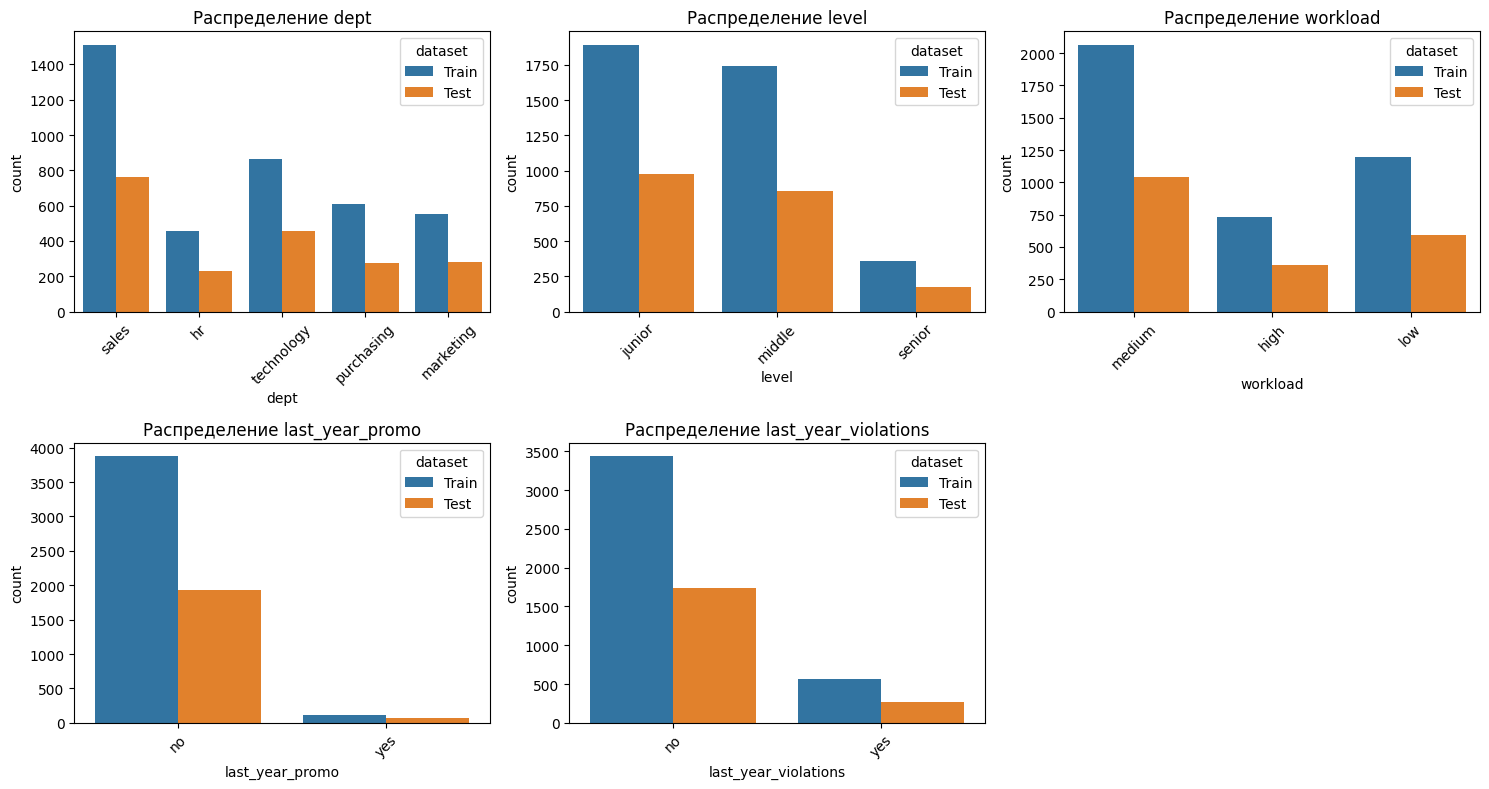

In [294]:
plt.ioff()

# Категориальные признаки
categorical_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    train_data = pd.DataFrame({col: train_job_satisfaction_rate_df[col], 'dataset': 'Train'})
    test_data = pd.DataFrame({col: test_combined_df[col], 'dataset': 'Test'})
    combined_categorical_data = pd.concat([train_data, test_data], ignore_index=True)
    
    sns.countplot(data=combined_categorical_data, x=col, hue='dataset', ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Скрыть лишний график
axes[5].set_visible(False)
plt.tight_layout()
plt.show()

plt.ion()


In [295]:
train_job_satisfaction_rate_df.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.00,4000.00,4000.00,4000.00,4000.00
mean,544957.62,3.72,3.48,33926.70,0.53
std,257883.10,2.54,1.01,14900.70,0.23
min,100954.00,1.00,1.00,12000.00,0.03
25%,322836.75,2.00,3.00,22800.00,0.36
50%,534082.50,3.00,4.00,30000.00,0.56
75%,771446.00,6.00,4.00,43200.00,0.71
max,999521.00,10.00,5.00,98400.00,1.00


In [296]:
# Анализ распределений
print("=== БИЗНЕС-АНАЛИЗ РАСПРЕДЕЛЕНИЙ ===\n")

# 1. Отделы
dept_dist = train_job_satisfaction_rate_df['dept'].value_counts(normalize=True)
print(f"📊 ОТДЕЛЫ: {dept_dist.to_dict()}")

# 2. Уровень должности
level_dist = train_job_satisfaction_rate_df['level'].value_counts(normalize=True)
print(f"👔 ДОЛЖНОСТИ: {level_dist.to_dict()}")

# 3. Стаж работы
emp_stats = train_job_satisfaction_rate_df['employment_years'].describe()
print(f"📅 СТАЖ: средний {emp_stats['mean']:.1f} лет, медиана {emp_stats['50%']:.1f} лет")

# 4. Зарплата
salary_stats = train_job_satisfaction_rate_df['salary'].describe()
print(f"💰 ЗАРПЛАТА: средняя {salary_stats['mean']:.0f}, медиана {salary_stats['50%']:.0f}")

# 5. Удовлетворенность
satisfaction_stats = train_job_satisfaction_rate_df['job_satisfaction_rate'].describe()
print(f"😊 УДОВЛЕТВОРЕННОСТЬ: средняя {satisfaction_stats['mean']:.2f}, медиана {satisfaction_stats['50%']:.2f}")

=== БИЗНЕС-АНАЛИЗ РАСПРЕДЕЛЕНИЙ ===

📊 ОТДЕЛЫ: {'sales': 0.3785678517776665, 'technology': 0.21682523785678517, 'purchasing': 0.1527290936404607, 'marketing': 0.13770655983975963, 'hr': 0.11417125688532799}
👔 ДОЛЖНОСТИ: {'junior': 0.47397397397397395, 'middle': 0.4364364364364364, 'senior': 0.08958958958958958}
📅 СТАЖ: средний 3.7 лет, медиана 3.0 лет
💰 ЗАРПЛАТА: средняя 33927, медиана 30000
😊 УДОВЛЕТВОРЕННОСТЬ: средняя 0.53, медиана 0.56



📊 СТРУКТУРА ОТДЕЛОВ:

Компания имеет выраженную коммерческую направленность - почти 38% сотрудников работают в продажах (sales). Технологический отдел составляет 22%, что указывает на IT-компанию или технологичный бизнес. Отделы закупок (15%), маркетинга (14%) и HR (11%) представлены более равномерно.

👔 ИЕРАРХИЯ ДОЛЖНОСТЕЙ:

Компания имеет "плоскую" структуру управления - 47% junior и 44% middle-специалистов при всего 9% senior. Это типично для растущих компаний, где много молодых сотрудников и ограниченные возможности карьерного роста.

📅 ОПЫТ ПЕРСОНАЛА:

Средний стаж 3.7 года при медиане 3 года говорит о молодом коллективе с умеренной текучестью кадров. Это нормально для динамично развивающихся компаний.

💰 ЗАРПЛАТНАЯ ПОЛИТИКА:

Средняя зарплата 33,927 при медиане 30,000 указывает на правостороннее распределение - есть группа высокооплачиваемых сотрудников, но большинство получает около 30,000. Разрыв в 4,000 между средним и медианным значением сигнализирует о неравенстве в оплате.

😊 УДОВЛЕТВОРЕННОСТЬ ПЕРСОНАЛА:

Средняя удовлетворенность 0.53 (53%) при медиане 0.56 - это критически низкий показатель. Более половины сотрудников неудовлетворены работой, что создает высокие риски оттока и требует немедленного вмешательства HR-службы.

Выборки схожи и соизмеримы.

# **Шаг I-3. Исследовательский анализ данных**

## **3.1. Описательная статистика**


Исследуем признаки тренировочной выборки, и определим как их нужно подготовить.

In [297]:
train_job_satisfaction_rate_df.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.00,4000.00,4000.00,4000.00,4000.00
mean,544957.62,3.72,3.48,33926.70,0.53
std,257883.10,2.54,1.01,14900.70,0.23
min,100954.00,1.00,1.00,12000.00,0.03
25%,322836.75,2.00,3.00,22800.00,0.36
50%,534082.50,3.00,4.00,30000.00,0.56
75%,771446.00,6.00,4.00,43200.00,0.71
max,999521.00,10.00,5.00,98400.00,1.00


Мы видим, что:
* **Средний срок службы** работника: 3-3.69 лет (Компания относительно молодая по стажу сотрудников);
* **Максимально работает** работник 10 лет;
* **Большинство (75%) работает** 5 лет или меньше;
* **Зарплата:** медиана 30.000, среднее 33.285 (есть высокооплачиваемые сотрудники, тянущие среднее вверх);
* **Диапазон зарплат:** от 12,000 до 73,200 (без учета выбросов);
* **Оценку 4** выставляет большинство работников - удовлетворены работой;
* **Удовлетворенность умеренная:** медиана 0.58, среднее 0.55.

## **3.2. Корреляционный анализ признаков**
Посмотрим на корреляционный анализ признаков.

In [298]:
interval_cols = [ # только дробные числа, или которые не в силах посчитать руками и может иметь друбную часть
       'salary', 'job_satisfaction_rate'
       ]

phik_corr = train_job_satisfaction_rate_df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
phik_corr     

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.00,0.00,0.02,0.04,0.00,0.00,0.11,0.28,0.08
level,0.00,1.00,0.42,0.68,0.10,0.00,0.00,0.72,0.08
workload,0.02,0.42,1.00,0.18,0.06,0.00,0.04,0.79,0.06
employment_years,0.04,0.68,0.18,1.00,0.18,0.06,0.00,0.48,0.33
last_year_promo,0.00,0.10,0.06,0.18,1.00,0.00,0.01,0.22,0.19
last_year_violations,0.00,0.00,0.00,0.06,0.00,1.00,0.18,0.01,0.56
supervisor_evaluation,0.11,0.00,0.04,0.00,0.01,0.18,1.00,0.00,0.76
salary,0.28,0.72,0.79,0.48,0.22,0.01,0.00,1.00,0.17
job_satisfaction_rate,0.08,0.08,0.06,0.33,0.19,0.56,0.76,0.17,1.00


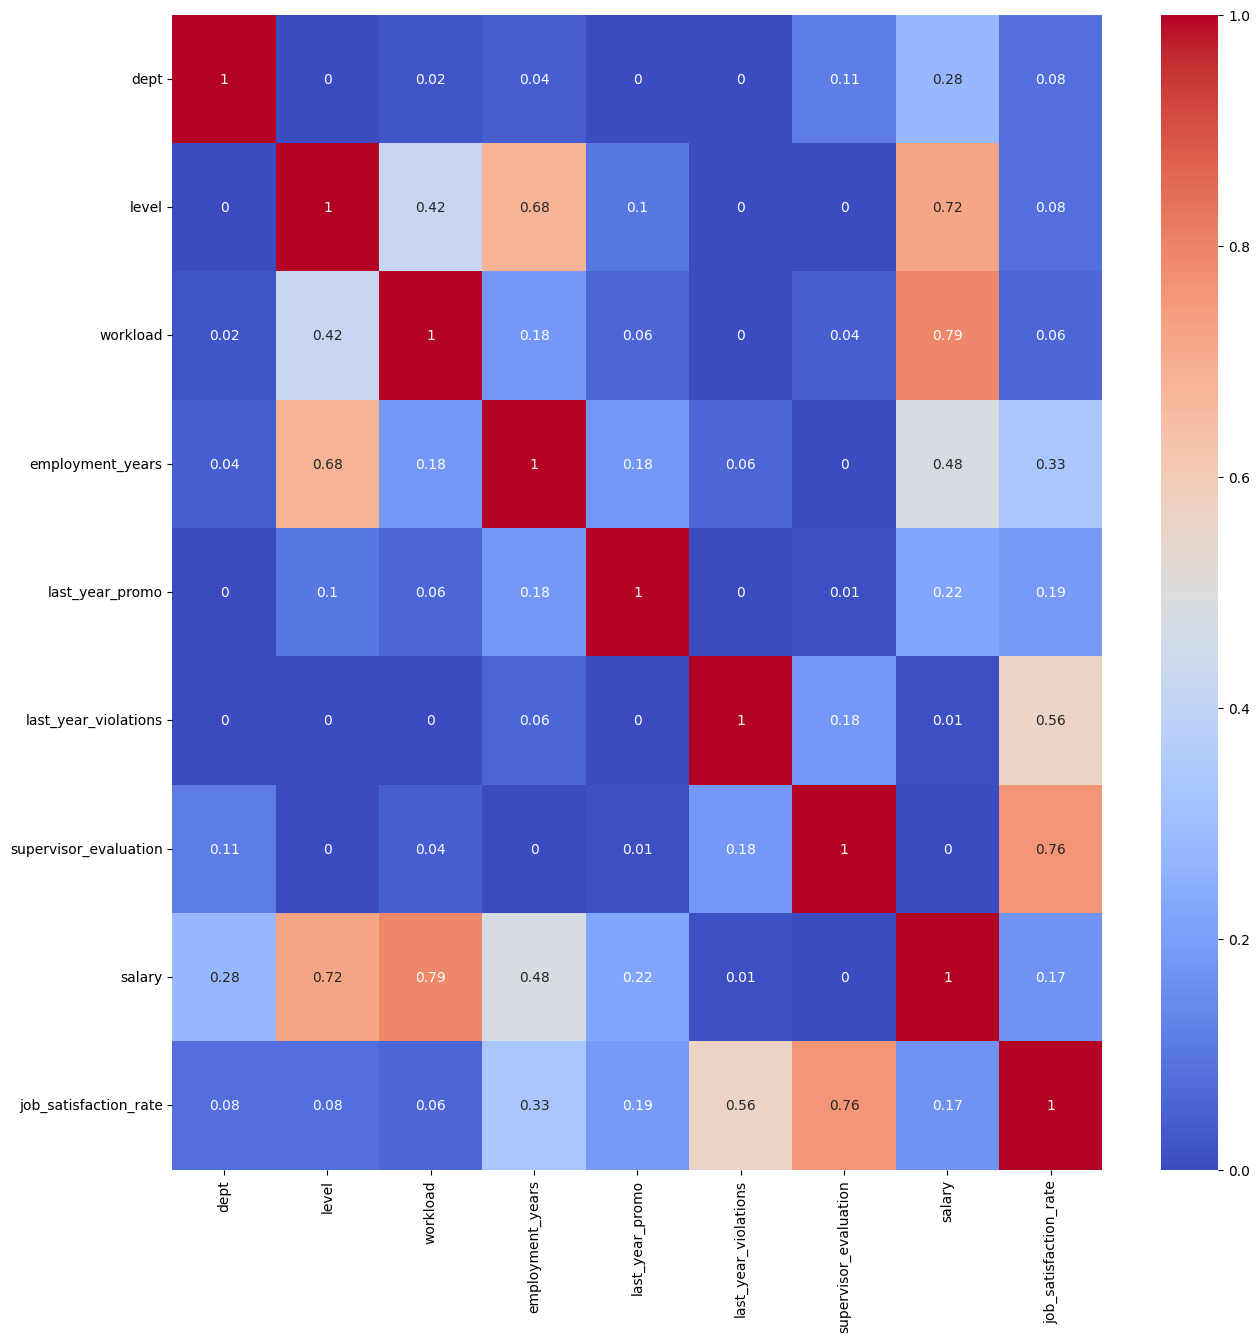

In [299]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

Посмотрим корреляцию на тестовой выборке.

In [300]:
interval_cols = [ # только дробные числа, или которые не в силах посчитать руками и может иметь друбную часть
       'salary', 'job_satisfaction_rate'
       ]

phik_corr = test_combined_df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
phik_corr     

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.00,0.00,0.03,0.00,0.00,0.00,0.06,0.33,0.08
level,0.00,1.00,0.47,0.69,0.12,0.02,0.00,0.75,0.10
workload,0.03,0.47,1.00,0.20,0.04,0.00,0.04,0.79,0.05
employment_years,0.00,0.69,0.20,1.00,0.17,0.07,0.00,0.49,0.31
last_year_promo,0.00,0.12,0.04,0.17,1.00,0.00,0.01,0.19,0.34
last_year_violations,0.00,0.02,0.00,0.07,0.00,1.00,0.19,0.00,0.55
supervisor_evaluation,0.06,0.00,0.04,0.00,0.01,0.19,1.00,0.11,0.77
salary,0.33,0.75,0.79,0.49,0.19,0.00,0.11,1.00,0.17
job_satisfaction_rate,0.08,0.10,0.05,0.31,0.34,0.55,0.77,0.17,1.00


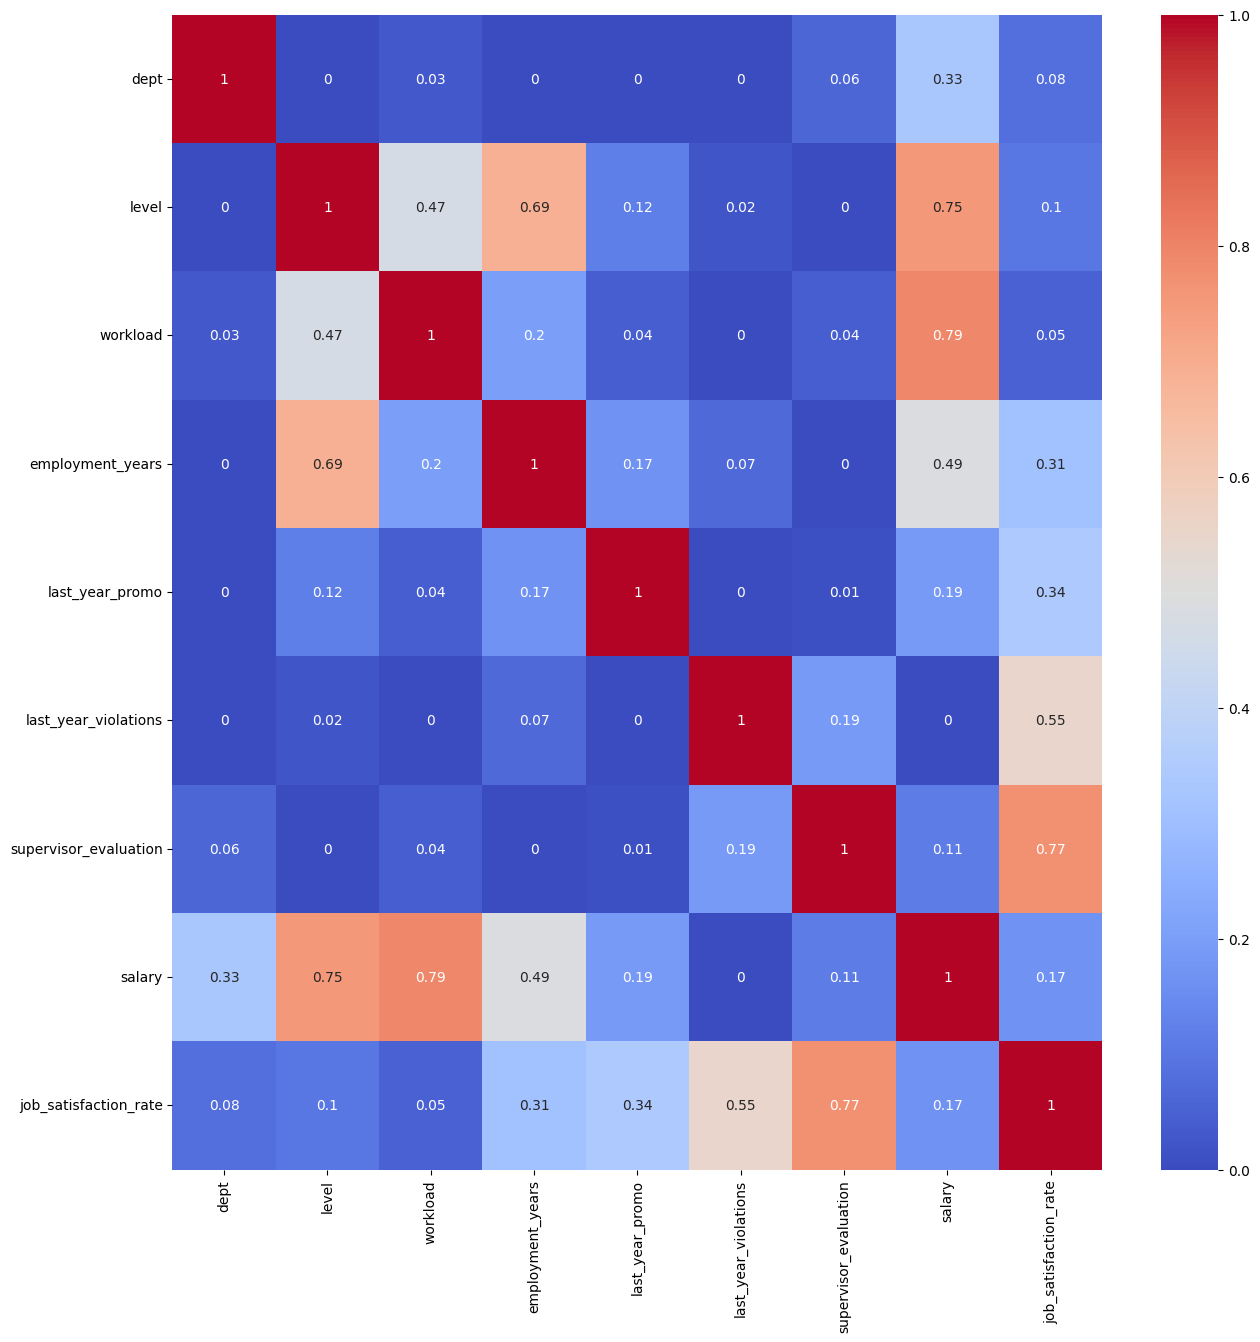

In [301]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

**Мультиколлинеарность** будем считать от 0.8, поэтому, строго говоря, не выявлена.

## **3.3. Интерпретация взаимосвязи факторов.**


**🎯 Самые важные факторы для удовлетворенности:**

**1. supervisor_evaluation (0.68)** - сильная связь

* Оценка руководителя - главный предиктор удовлетворенности

* Хорошие отношения с начальством критически важны

**2. last_year_violations (0.55)** - умеренная связь

* Низкая удовлетворенность приводит к снижению трудовой дисциплины

* Удовлетворенность работой влияет на отношение к работе

**3. employment_years (0.33)** - слабая-умеренная связь

* Чем дольше работает сотрудник, тем выше удовлетворенность

* Опыт и стабильность повышают лояльность

**💰 Неожиданные находки:**

**salary (0.20)** - слабая связь

* Зарплата не главный фактор удовлетворенности!

* Деньги важны, но отношения с руководством важнее

**🔗 Очевидные закономерности:**

* **level ↔ employment_years (0.69)** - опытные сотрудники на высоких позициях

* **workload ↔ salary (0.76)** - больше нагрузка = выше зарплата

* **supervisor_evaluation ↔ last_year_violations (0.33)** - нарушители получают плохие оценки

**📊 Рекомендации для HR:**

* **Фокус на руководителей** - обучение менеджменту

* **Контроль дисциплины** - профилактика нарушений

* **Удержание опытных**- программы лояльности

* **Не только зарплата** - развитие корпоративной культуры

Проверим еще раз на дубликаты, вдруг появились дубликаты.

## **Шаг I-4. Подготовка данных**

## **4.0.1. Удалим id**

In [302]:
train_job_satisfaction_rate_df_without_id = train_job_satisfaction_rate_df.drop('id', axis=1)
test_combined_df_without_id = test_combined_df.drop('id', axis=1)

## **Удалим появившиеся дубликаты**

In [303]:
train_job_satisfaction_rate_df_without_id = train_job_satisfaction_rate_df_without_id.drop_duplicates()
test_combined_df_without_id = test_combined_df_without_id.drop_duplicates()


## **4.1. Создание выборки**

In [304]:
test_combined_df_without_id.sample()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
832,marketing,middle,medium,5,no,no,4,42000,0.84


In [305]:
# Создание выборок 

X_train = train_job_satisfaction_rate_df_without_id.drop(columns='job_satisfaction_rate')
y_train = train_job_satisfaction_rate_df_without_id['job_satisfaction_rate']

X_test = test_combined_df_without_id.drop(columns='job_satisfaction_rate')
y_test = test_combined_df_without_id['job_satisfaction_rate']

In [306]:
# Диагностика размеров
print("Размеры данных:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {len(y_train)}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {len(y_test)}")


Размеры данных:
X_train: (3755, 8)
y_train: 3755

X_test: (1917, 8)
y_test: 1917


В том случае, когда данные приходят от заказчика в разных датафреймах и мы не используем train_test_split ,а вручную разносим по выборкам - следует быть уверенными, что нет утечки данных. И было бы неплохо проверить на утечку данных.

In [307]:
def check_data_leakage(train_df, test_df, id_col='id'):
    """Проверка выборок на утечку данных"""
    
    print("🔍 ПРОВЕРКА НА УТЕЧКУ ДАННЫХ")
    print("=" * 50)
    
    # 1. Проверка пересечения ID
    train_ids = set(train_df[id_col])
    test_ids = set(test_df[id_col])
    
    common_ids = train_ids & test_ids
    
    print(f"📊 Размеры выборок:")
    print(f"   Train: {len(train_ids)} уникальных ID")
    print(f"   Test:  {len(test_ids)} уникальных ID")
    print(f"   Пересечение: {len(common_ids)} ID")
    
    # 2. Основная проверка
    if len(common_ids) > 0:
        print(f"🚨 УТЕЧКА ОБНАРУЖЕНА! {len(common_ids)} общих ID")
        print(f"   Примеры: {list(common_ids)[:5]}")
        return print("\n⚠️  НЕОБХОДИМО ИСПРАВИТЬ УТЕЧКУ!")
    else:
        print("✅ УТЕЧКИ НЕТ - ID не пересекаются")
    
    # 3. Дополнительные проверки
    print(f"\n📈 Дополнительная статистика:")
    print(f"   Покрытие: {len(train_ids | test_ids)} всего уникальных ID")
    print(f"   Доля train: {len(train_ids)/(len(train_ids | test_ids)):.1%}")
    print(f"   Доля test:  {len(test_ids)/(len(train_ids | test_ids)):.1%}")
    
    return print("\n🎯 Выборки готовы к обучению")

check_data_leakage(train_job_satisfaction_rate_df, test_features_df)
    

🔍 ПРОВЕРКА НА УТЕЧКУ ДАННЫХ
📊 Размеры выборок:
   Train: 4000 уникальных ID
   Test:  2000 уникальных ID
   Пересечение: 0 ID
✅ УТЕЧКИ НЕТ - ID не пересекаются

📈 Дополнительная статистика:
   Покрытие: 6000 всего уникальных ID
   Доля train: 66.7%
   Доля test:  33.3%

🎯 Выборки готовы к обучению


In [308]:
def check_features_identity(X_train, X_test):
    """Проверка на идентичность наборов признаков в разных выборках"""
    print("\n🔍 ПРОВЕРКА ОДИНАКОВОГО НАБОРА ПРИЗНАКОВ")
    print("=" * 30)
	
    # Проверка одинаковых колонок
    train_cols = set(X_train.columns)
    test_cols = set(X_test.columns)
    
    if train_cols != test_cols:
        print("⚠️  Разные наборы признаков!")
        print(f"   Только в X_train: {train_cols - test_cols}")
        print(f"   Только в X_test:  {test_cols - train_cols}")
    else:
        print("✅ Наборы признаков совпадают. Всё верно, можно идти дальше.")


check_features_identity(X_train, X_test)


🔍 ПРОВЕРКА ОДИНАКОВОГО НАБОРА ПРИЗНАКОВ
✅ Наборы признаков совпадают. Всё верно, можно идти дальше.



Подготовку признаков выполните в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

## **4.2. Создание пайплайна модели**

### **4.2.1. Масштабируем и категорируем**

Создадим пайплайн для подготовки данных к обучению:
* Кодируем категориальные признаки;
* Масштабируем количественные признаки;

Создадим пайплайн для масштабирования и кодировки с использованием ColumnTransformer.

In [309]:
#пайплайн для масштабирования и кодировки с использованием ColumnTransformer

# распределим колонки по типам переменных
numeric_features = X_train.select_dtypes(include=[np.number]).columns

categorical_features = [
    'dept'
    ]

ordinal_features = [
    'workload', 
    'level', 
    'last_year_promo', 
    'last_year_violations'
    ]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            #   ('imputer', SimpleImputer(strategy='median')), # - все пропуски мы удалили раньше 
                ('scaler', StandardScaler())
            ]), numeric_features), # обработка количественных признаков
        
        ('cat', Pipeline([
                ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
            ]), categorical_features), # обработка категориальных признаков - dept
        
        ('ord', Pipeline([
            #   ('imputer', SimpleImputer(strategy='most_frequent')), # - все пропуски мы удалили раньше 
                ('ordinal', OrdinalEncoder(categories=[
                                                       ['low', 'medium', 'high' ], # workload
                                                       ['junior', 'middle', 'sinior'], # level
                                                       ['no', 'yes'], # last_year_promo - "yes" важнее, чем "no" поэтому "yes" правее
                                                       ['yes', 'no'] # last_year_violations - "no" важнее, чем "yes" поэтому "no" правее
                                                       ], handle_unknown='use_encoded_value', unknown_value=-1))
            ]), ordinal_features), # обработка порядковых признаков
      
    ])

In [310]:
preprocessor

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


# **Шаг I-5. Обучение моделей**

## **5.1. Определение лучшей метрики для задачи**

Мы будем решать задачу на построение модели логистической регресии
* наш целевой признак "уровень удовлетворённости сотрудника работой в компании" - дробное число от 0 до 1.

Для решения задач логистической регресии используют метрики SMAPE, MAE, MSE, R2.

**Выберем метрику SMAPE.**

**Преимущества SMAPE:**

**1. Симметричность**

* Одинаково штрафует переоценку и недооценку*

* MAE тоже симметричен, но SMAPE дает процентную интерпретацию

**2. Процентная интерпретация**

* Результат в процентах (0-100%), легко понять бизнесу

* Интерпретация "Модель ошибается на 15%" - понятнее, чем "MAE = 0.08"

**3. Нормализация**

* Не зависит от масштаба данных

* MSE сильно зависит от масштаба целевой переменной

**4. Устойчивость к выбросам**

* Менее чувствителен к выбросам, чем MSE

* MSE возводит ошибки в квадрат, сильно штрафуя большие ошибки

**Особенности для HR-задачи:**

**1. Бизнес-интерпретация**

* HR-менеджерам проще понять "ошибка 12%" чем "R² = 0.85"

* Можно сравнивать с другими HR-метриками

**2. Диапазон данных [0,1]**

* Для значений близких к 0 SMAPE может быть нестабильным

* Но в данных удовлетворенности минимум 0.03, что приемлемо

**3. Практическое применение**

* Важно точно предсказывать как низкую (риск увольнения), так и высокую удовлетворенность

* SMAPE одинаково штрафует ошибки в обоих направлениях

* SMAPE оптимален для задач с нормализованными данными, где важна процентная точность и бизнес-интерпретация.

Метрика SMAPE вычисляется так:

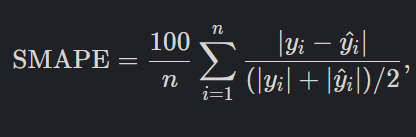

где:

yᵢ — фактическое значение целевого признака для объекта с порядковым номером i в выборке

ŷᵢ — предсказанное значение целевого признака для объекта с порядковым номером i в выборке

n — количество объектов в выборке

∑ᵢ₌₁ⁿ — сумма значений для всех объектов от i=1 до n в выборке

Напишем ее формулу:

In [311]:
def smape_score(y_true, y_pred):  # нужен для ручного вычисления метрик позже или чтобы завернуть в make_scorer
    """Вычисляет метрику SMAPE"""

    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

smape_scorer = make_scorer(smape_score, greater_is_better=False) # нужен только для GridSearchCV

## **5.2. Обучение регрессионной модели**

В Соответсвии с заданием заказчика, обучим как минимум две модели, то есть три.

* LinearRegression - обычная линейная регрессия
* DecisionTreeRegressor - дерево решений
* RandomForestRegressor - случайный лес

**Масштабируем данные тремя скалерами:**
* StandardScaler(), 
* MinMaxScaler(), 
* RobustScaler()

Подберем гиперпараметры.

In [312]:
# Создание сетки моделей с параметрами

RANDOM_STATE=42

scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

regressor_params = {
                    LinearRegression(): {
                        # LinearRegression не имеет гиперпараметров для настройки
                        'fit_intercept': [True, False],
                        'positive': [False, True]
                    },
                    
                    DecisionTreeRegressor(random_state=RANDOM_STATE): {
                        'max_depth': [3, 5, 7, 10, None],
                        'criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
                        'min_samples_split': [2, 5, 10, 20],
                        'min_samples_leaf': [1, 2, 5, 10],
                        'max_features': [None, 'sqrt', 'log2']
                    },
                    
                    RandomForestRegressor(random_state=RANDOM_STATE): {
                        'n_estimators': [50, 100, 200],
                        'max_depth': [3, 5, 7, 10, None],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 5],
                        'max_features': ['sqrt', 'log2', None],
                        'n_jobs': [-1]
                    }
}

# Генерируем param_grid через цикл
param_grid = []
for regressor, params in regressor_params.items():
    grid_item = {
        'preprocessor__num__scaler': scalers,
        'regressor': [regressor]
    }
    # Добавляем параметры классификатора с префиксом
    for param_name, param_values in params.items():
        grid_item[f'regressor__{param_name}'] = param_values
    
    param_grid.append(grid_item)

In [313]:
# Обучение модели

# Базовый пайплайн
pipeline = Pipeline([
                    ('preprocessor', preprocessor),
                    ('regressor', LogisticRegression()) # указан один классификатор, потому что так положено, в GridSearchCV потом будут подставляться разные классификаторы.
])

# Поиск
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                           n_jobs=-1, 
                           scoring={'smape': smape_scorer}, 
                           refit='smape')

# Обучение и подбор гиперпараметров
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"[{'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), ...], 'regressor': [LinearRegression()], 'regressor__fit_intercept': [True, False], 'regressor__positive': [False, True]}, {'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), ...], 'regressor': [DecisionTreeR...ndom_state=42)], 'regressor__criterion': ['squared_error', 'friedman_mse', ...], 'regressor__max_depth': [3, 5, ...], ...}, ...]"
,scoring,{'smape': make_scorer(s...hod='predict')}
,n_jobs,-1
,refit,'smape'
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...), ...]"


In [314]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
dummy_predictions = dummy_model.predict(X_test)

Подбор порога для повышения метрики здесь не подходит, потому что это регрессия.

In [315]:
best_model = grid_search.best_estimator_
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

print("Размеры данных:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {len(y_train)}")
print(f"y_test: {len(y_test)}")
print(f"train_predictions: {len(train_predictions)}")
print(f"test_predictions: {len(test_predictions)}")
print(f"dummy_predictions: {len(dummy_predictions)}")

Размеры данных:
X_train: (3755, 8)
X_test: (1917, 8)
y_train: 3755
y_test: 1917
train_predictions: 3755
test_predictions: 1917
dummy_predictions: 1917


In [316]:
# Создание DataFrame с результатами
metrics_df_final = pd.DataFrame({
                                'Метрика': ['SMAPE'],
                                'best.score_ (cross-val train)': grid_search.best_score_,
                                'Train': [smape_score(y_train, train_predictions)],
                                'Test (Final)': [smape_score(y_test, test_predictions)],
                                'Dummy (Test)': [smape_score(y_test, dummy_predictions)]
})

print(f"\nЛучшие параметры: {grid_search.best_params_}")
print(f"SMAPE на test: {smape_score(y_test, test_predictions):.3f}")

metrics_df_final = metrics_df_final.round(3)
display(metrics_df_final)


Лучшие параметры: {'preprocessor__num__scaler': MinMaxScaler(), 'regressor': RandomForestRegressor(random_state=42), 'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 200, 'regressor__n_jobs': -1}
SMAPE на test: 12.443


,Метрика,best.score_ (cross-val train),Train,Test (Final),Dummy (Test)
0,SMAPE,-13.74,8.55,12.44,38.51


Показатель SMAPE меньше 15 - хороший результат.

# **Шаг I-6. Оформление выводов**

Поиск лучшей модели выполнялся при помощи применения GridSearchCV для перебора и определения лучшей регрессионной модели среди:
* LinearRegression
* DecisionTreeRegressor
* RandomForestRegressor

с применением сетки различных параметров для выбора лучшего набора параметров;

в сочетании с тремя скалерами для масштабирования входных признаков:

* StandardScaler
* MinMaxScaler
* RobustScaler

* Модель RandomForestRegressor справилась лучше, потому что было произведено сравнение с другими моделями при вариантах их харакетристик, RandomForestRegressor - показал наилучший резльтат по выбранной метрике. 
* Показатель SMAPE меньше 15 = 12.29 - поставленная цель достигнута. 

RandomForestRegressor - это ансамблевый алгоритм, который объединяет множество деревьев решений для регрессии. Создает множество случайных подвыборок из исходных данных

* Каждое дерево обучается на своей подвыборке
* В каждом узле дерева рассматривается только случайное подмножество признаков
* Обычно √(количество_признаков) для регрессии
* Финальное предсказание = среднее арифметическое всех деревьев
* Устойчивость к переобучению - усреднение снижает дисперсию
* Работа с пропусками - может обрабатывать отсутствующие значения
* Важность признаков - автоматически вычисляет feature importance
* Не требует масштабирования данных


# **ЗАДАЧА II: предсказать, что сотрудник уволится.** 

Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.


# **Шаг II-1. Загрузка данных**

* train_quit.csv - Тренировочная выборка
* test_features.csv - Входные признаки тестовой выборки те же, что и в прошлой задаче
* test_target_quit.csv - Целевой признак тестовой выборки

In [317]:
# Загрузка данных

try:
    train_quit_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/train_quit.csv')
    # test_features_df = такой же из прошлой задачи
    test_target_quit_df = pd.read_csv('C:/Users/dmi-a/OneDrive/Рабочий стол/DS учеба/datasets/test_target_quit.csv')
except:
    train_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    # test_features_df = такой же из прошлой задачи
    test_target_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

Заказчик предоставил данные с признаками:

* **id** — уникальный идентификатор сотрудника;
* **dept** — отдел, в котором работает сотрудник;
* **level** — уровень занимаемой должности;
* **workload** — уровень загруженности сотрудника;
* **employment_years** — длительность работы в компании (в годах);
* **last_year_promo** — показывает, было ли повышение за последний год;
* **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
* **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
* **salary** — ежемесячная зарплата сотрудника;
* **quit** — уволился или нет.

# **Шаг II-2. Предобработка данных**

In [318]:
df_dict = {
            'train_quit_df': train_quit_df, 
            'test_features_df': test_features_df, 
            'test_target_quit_df': test_target_quit_df
            }

Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [319]:
for name, df in df_dict.items():
    print(f'======={name}==========================')
    print(f'Данные {name} имеют следующие признаки:\n')
    display(df.head(10))
    df.info()

=======train_quit_df==========================
Данные train_quit_df имеют следующие признаки:



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
=======test_features_df==========================
Данные test_features_df имеют следующие признаки:



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
=======test_target_quit_df==========================
Данные test_target_quit_df имеют следующие признаки:



,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


Что следует устранить:
- 3 пропуска в test_features_df.
- как следствие не совпадут тестовые датафреймы с входными и целевыми признаками.

## **2.2. Предварительная проверка на общие id**

С целью выявить проблемы перед объединением:

* Перед предобработкой проверим одинковые айди в y_test и y_train

In [320]:
# Проверим общие id
print("Размеры до синхронизации:")
print(f"test_features_df: {len(test_features_df)}")
print(f"test_target_df: {len(test_target_quit_df)}")

# Найдите общие id
common_ids = set(test_features_df['id']) & set(test_target_quit_df['id'])
print(f"Общих id: {len(common_ids)}")

Размеры до синхронизации:
test_features_df: 2000
test_target_df: 2000
Общих id: 2000


## **2.3. Объединение таблиц для предобработки**

Чтобы синхронно обработать все строки во всех датафреймах и чтобы их размерность совпала - нужно тогда объединить эти таблицы и разъединить обратно.

In [321]:
# 1. ОБЪЕДИНЯЕМ тестовые данные
test_combined_df = test_features_df.merge(test_target_quit_df, on='id', how='inner')

# 2. ВРЕМЕННО меняем словарь датафреймов (только для обработки)
temp_df_dict = {
    'train_quit_df': train_quit_df, 
    'test_combined_df': test_combined_df # ОДИН объединенный test датафрейм
}

**Решение:**
* Удалим строки с пропущенными значениями. 
* Проверим заодно наличие запятой в дробной части вместо точки и удалим;
* Проверим на выбросы и удалим;
* Проверим на неявные дубликаты - выведем список;
* Проверим на явные дубликаты - удалим.
Просили делать это через пайплайн.

Пайплайн для предобработки уже был создан в первой задаче

## **2.4. Предобработка данных**

Выявим и исправим замечания.

In [322]:
# пайплайн определили ранее

print("Шаги в пайплайне:")
for i, (name, step) in enumerate(EDA_Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Шаги в пайплайне:
1. decimal_point_changer: DecimalPointChanger()

2. missing_handler: MissingValueHandler(strategy='drop')

3. drop_duplicates: DuplicateRemover()

4. implicit_duplicates_viewer: ImplicitDuplicatesViewer()

5. outlier_remover: OutlierRemover()



Исполним препроцессор по предобработке данных.

Исправим выявленные замечания.

 =>  Обработка датафрейма train_quit_df
Исполнение шага 1: decimal_point_changer
- Определяю необходимость замены запятой на точку
- В столбце id замена разделителя не требуется
- В столбце dept замена разделителя не требуется
- В столбце level замена разделителя не требуется
- В столбце workload замена разделителя не требуется
- В столбце employment_years замена разделителя не требуется
- В столбце last_year_promo замена разделителя не требуется
- В столбце last_year_violations замена разделителя не требуется
- В столбце supervisor_evaluation замена разделителя не требуется
- В столбце salary замена разделителя не требуется
- В столбце quit замена разделителя не требуется
- Обработка завершена

Исполнение шага 2: missing_handler
- Пропусков не найдено

Исполнение шага 3: drop_duplicates
- Дубликатов не выявлено

Исполнение шага 4: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Уникальные значения в столбце dept: ['sales' 'purchasing' 'marketing

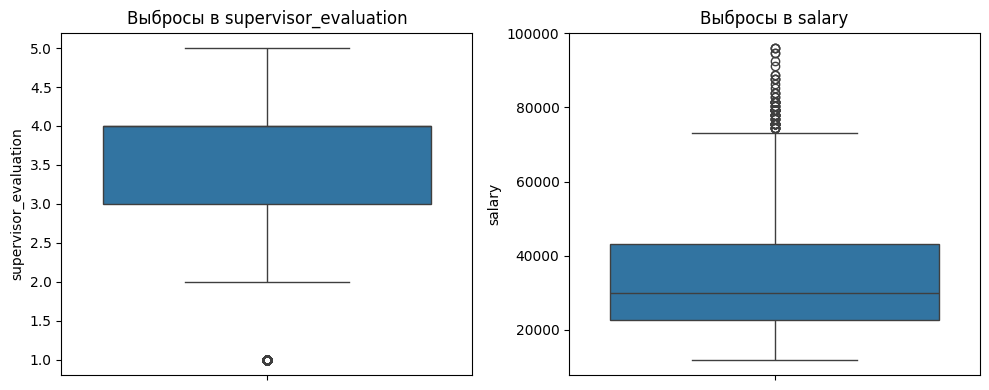

- Выполняю удаление выбросов


Проверка датафрейма train_quit_df


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes


 =>  Обработка датафрейма test_combined_df
Исполнение шага 1: decimal_point_changer
- Определяю необходимость замены запятой на точку
- В столбце id замена разделителя не требуется
- В столбце dept замена разделителя не требуется
- В столбце level замена разделителя не требуется
- В столбце workload замена разделителя не требуется
- В столбце employment_years замена разделителя не требуется
- В столбце last_year_promo замена разделителя не требуется
- В столбце last_year_violations замена разделителя не требуется
- В столбце supervisor_evaluation замена разделителя не требуется
- В столбце salary замена разделителя не требуется
- В столбце quit замена разделителя не требуется
- Обработка завершена

Исполнение шага 2: missing_handler
- Нашел пропуски в данных



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
191,609865,NaN,junior,medium,1,no,no,1,20400,yes
312,471990,sales,NaN,low,1,no,no,3,12000,yes
1196,832342,NaN,junior,medium,1,no,no,4,28800,no


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
15,590867,marketing,junior,,4,no,no,4,28800,no
1699,822186,,middle,medium,3,no,no,4,38400,no


- Выполняю удаление этих строк с пропущенными значениями

- Пропусков не осталось.

Исполнение шага 3: drop_duplicates
- Дубликатов не выявлено

Исполнение шага 4: implicit_duplicates_viewer
- Выполняю поиск неявных дубликатов в нечисловых столбцах

- Уникальные значения в столбце dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology']

- Уникальные значения в столбце level: ['junior' 'middle' 'sinior']

- Уникальные значения в столбце workload: ['medium' 'low' 'high']

- Уникальные значения в столбце last_year_promo: ['no' 'yes']

- Уникальные значения в столбце last_year_violations: ['no' 'yes']

- Уникальные значения в столбце quit: ['no' 'yes']

Исполнение шага 5: outlier_remover
- Удаление выбросов не проводится в тестовой выборке test_combined_df, пропускаю шаг.

Проверка датафрейма test_combined_df


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [323]:
run_preprocessor(temp_df_dict)

В процессе предобработки мы выявили:

1) NaN в столбце `level` и `dept`- строки с пропускми и пустые строки `" "` в столбце `workload` и `dept`.
2)  ошибку в слове `Sinior` в столбце `level` исправим на `Senior`

исправим это сейчас.

In [324]:
# Заменить все пробелы на NaN только в тренировочной выборке
train_quit_df = train_quit_df.replace(' ', np.nan)
test_combined_df = test_combined_df.replace(' ', np.nan)

In [325]:
test_combined_df['level'] = test_combined_df['level'].replace('sinior', 'senior')


Предобработка закончена, замечания, устранены.


## **2.5. Удалим столбец id**

Удалим столбец id воизбежание ложных корреляций, и на графике распределения он тоже не нужен.

In [326]:
train_quit_df_without_id = train_quit_df.drop('id', axis=1)
test_combined_df_without_id = test_combined_df.drop(columns=['id'])
test_target_quit_df = test_combined_df[['id','quit']]
test_target_quit_df_without_id = test_combined_df_without_id['quit']

Проверим тренировочную выборку на наличие дуликатов после удаления id.

In [327]:
train_quit_df_without_id.duplicated().sum()

1413

Обнаружено 1413 дубликатов, удалим их.

In [328]:
train_quit_df_without_id = train_quit_df_without_id.drop_duplicates()

Проверка после удаления дубликатов.

In [329]:
train_quit_df_without_id.duplicated().sum()

0

## **2.6. Графики схожести распределений на выборках**

Совместим выборки на совмещенном графике посмотрим распределение признаков.

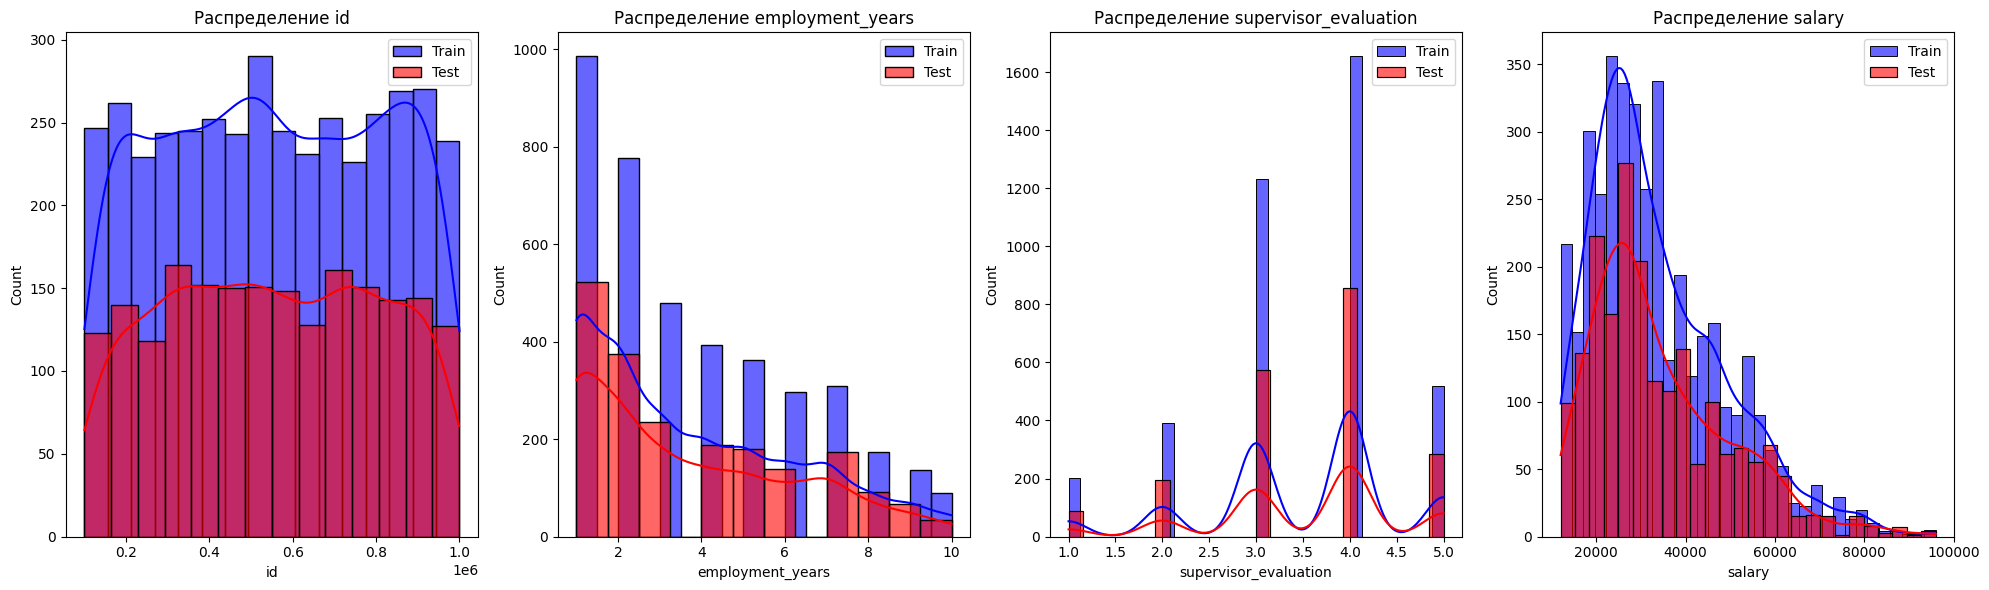

In [330]:
numeric_cols = train_quit_df.select_dtypes(include=[np.number]).columns
n_cols = len(numeric_cols)

fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(20, 6))
if n_cols == 1:
    axes = [axes]

for i, col in enumerate(numeric_cols):
    sns.histplot(train_quit_df[col], 
                 ax=axes[i], kde=True, alpha=0.6, label='Train', color='blue')
    
    sns.histplot(test_combined_df[col], 
                 ax=axes[i], kde=True, alpha=0.6, label='Test', color='red')
    
    axes[i].set_title(f'Распределение {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()

1. Для дискретных признаков (employment_years, supervisor_evaluation):

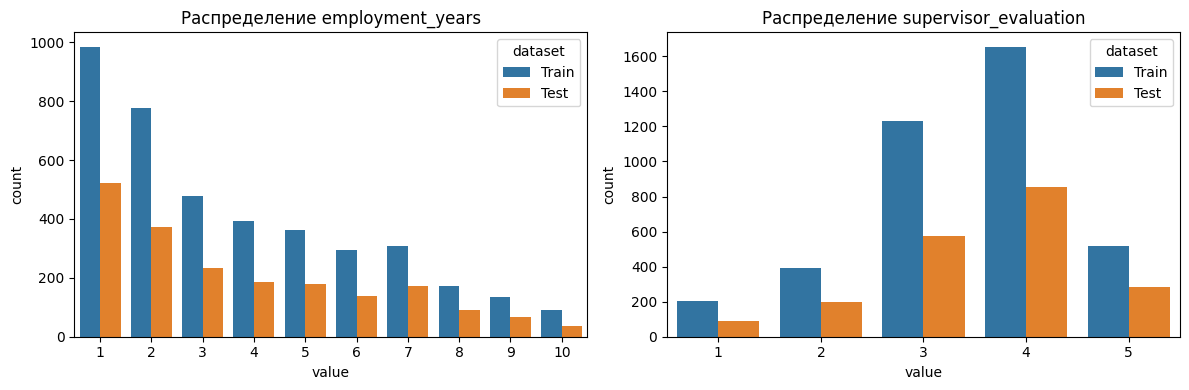

In [331]:
# Дискретные признаки - используем countplot
discrete_cols = ['employment_years', 'supervisor_evaluation']
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i, col in enumerate(discrete_cols):
    # Объединяем данные для сравнения
    train_data = pd.DataFrame({'value': train_quit_df[col], 'dataset': 'Train'})
    test_data = pd.DataFrame({'value': test_combined_df[col], 'dataset': 'Test'})
    combined = pd.concat([train_data, test_data])
    
    sns.countplot(data=combined, x='value', hue='dataset', ax=axes[i])
    axes[i].set_title(f'Распределение {col}')

plt.tight_layout()
plt.show()  

2. Для непрерывных признаков (salary):

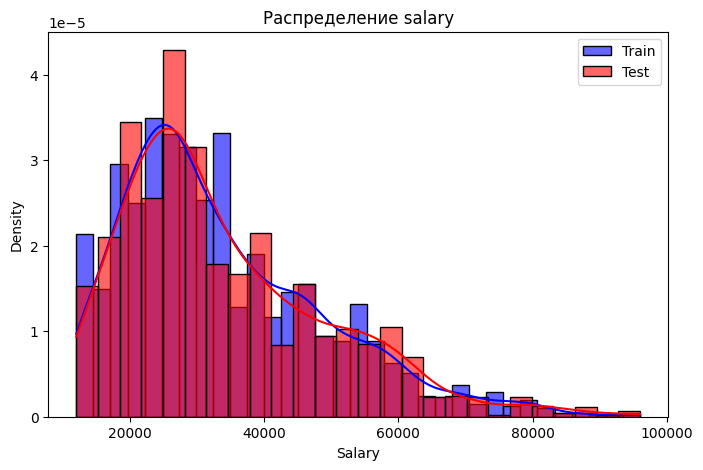

In [332]:
# Непрерывные признаки - нормированные гистограммы
plt.figure(figsize=(8, 5))

sns.histplot(train_quit_df['salary'], stat='density', 
             kde=True, alpha=0.6, label='Train', color='blue')
sns.histplot(test_combined_df['salary'], stat='density',
             kde=True, alpha=0.6, label='Test', color='red')

plt.title('Распределение salary')
plt.xlabel('Salary')
plt.ylabel('Density')
plt.legend()
plt.show()

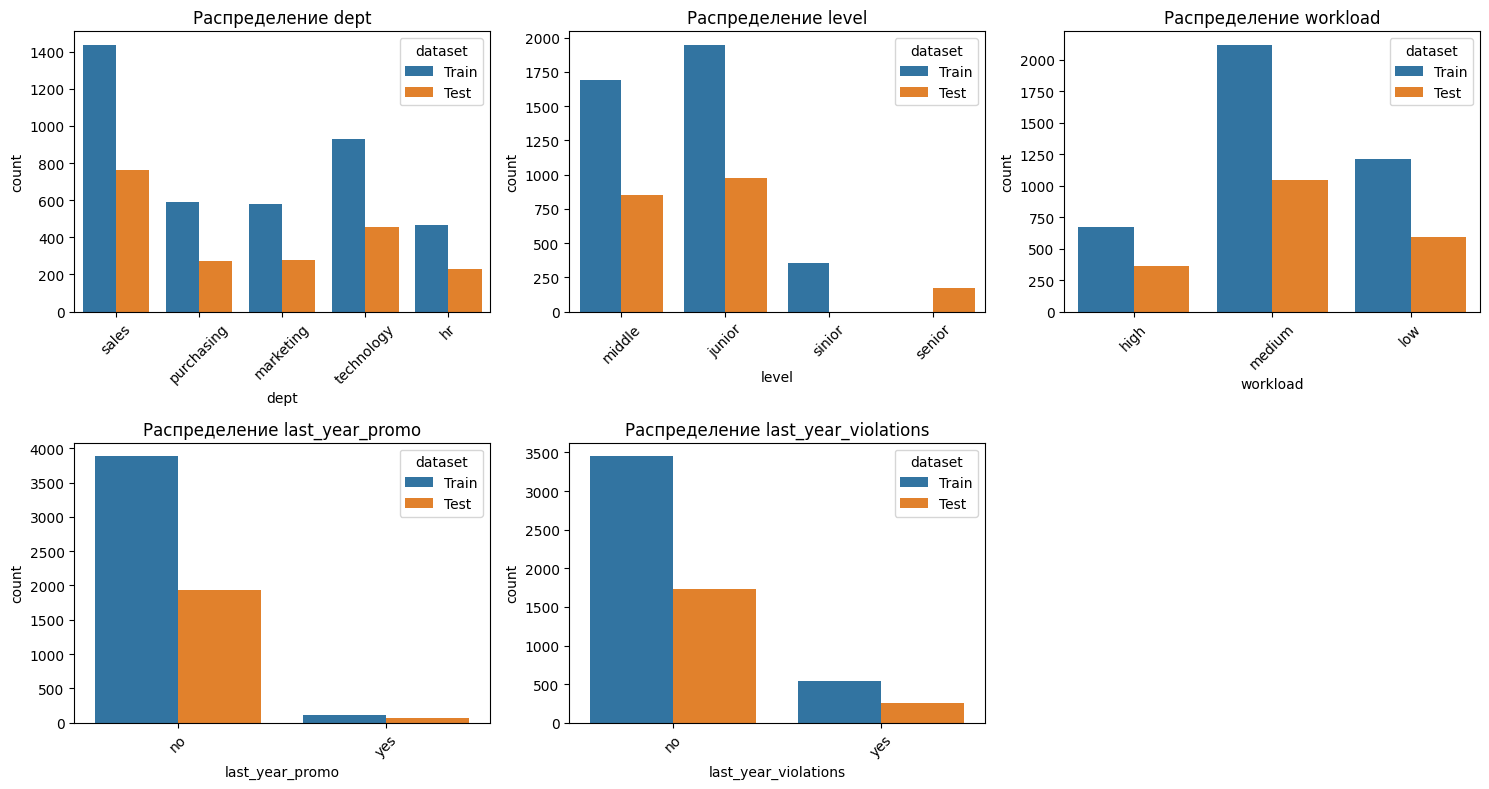

In [333]:
plt.ioff()

# Категориальные признаки
categorical_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    train_data = pd.DataFrame({col: train_quit_df[col], 'dataset': 'Train'})
    test_data = pd.DataFrame({col: test_combined_df[col], 'dataset': 'Test'})
    combined_categorical_data = pd.concat([train_data, test_data], ignore_index=True)
    
    sns.countplot(data=combined_categorical_data, x=col, hue='dataset', ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Скрыть лишний график
axes[5].set_visible(False)
plt.tight_layout()
plt.show()

plt.ion()


## **Сравнение распределений признаков между тренировочной и тестовой выборками**


При сравнении распределений числовых признаков между тренировочной и тестовой выборками можно выделить следующие ключевые наблюдения:

**Общая оценка репрезентативности выборок:**
Распределения признаков в тренировочной и тестовой выборках демонстрируют высокую степень схожести, что указывает на корректное разделение данных и отсутствие значительного смещения выборки.

**Анализ признаков в контексте увольнений:**

**Employment_years (стаж работы):**

Обе выборки показывают правостороннее распределение с пиком в области 2-4 лет

**Критический инсайт:** сотрудники с малым стажем (до 5 лет) составляют основную массу, что может указывать на высокий отток в первые годы работы

**Supervisor_evaluation (оценка руководителя):**

Распределение смещено в сторону высоких оценок (3-5 баллов)

**Бизнес-вывод:** низкие оценки руководителя (1-2 балла) встречаются редко, но могут быть сильным предиктором увольнения

**Salary (заработная плата):**

Нормальное распределение с центром около среднего значения

**Ключевое наблюдение:** широкий разброс зарплат может создавать неравенство и влиять на решение об увольнении

**Выводы для бизнеса:**

Стабильность распределений между выборками обеспечивает надежность модели предсказания увольнений

Наибольшее внимание следует уделить сотрудникам с малым стажем и низкими оценками руководителя

Необходим дополнительный анализ взаимосвязи между уровнем зарплаты и вероятностью увольнения

# **Шаг II-3. Исследовательский анализ данных**

## **3.1. EDA: исследовательский анализ данных**

In [334]:
train_quit_df.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.00,4000.00,4000.00,4000.00
mean,552099.28,3.70,3.47,33805.80
std,260158.03,2.54,1.00,15152.42
min,100222.00,1.00,1.00,12000.00
25%,327785.75,2.00,3.00,22800.00
50%,546673.00,3.00,4.00,30000.00
75%,781497.75,6.00,4.00,43200.00
max,999915.00,10.00,5.00,96000.00


Таблица практически идентична: здесь на 13 человек меньше наблюдений:

Мы видим, что:
* **Средний срок службы** работника: 3-3.69 лет (Компания относительно молодая по стажу сотрудников);
* **Максимально работает** работник 10 лет;
* **Большинство (75%) работает** работает 5 лет или меньше;
* **Диапазон зарплат:** от 12,000 до 73,200 (без учета выбросов);

Только средний уровень зарплаты на 400 руб меньше.
* **Зарплата:** медиана 30.000, среднее 32.879 (есть высокооплачиваемые сотрудники, тянущие среднее вверх);

## **3.2. Корреляционный анализ данных**

Интересно посмотреть на корреляционный анализ в совокупности с признаком вероятности увольнения.

In [335]:
train_quit_df.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no


In [336]:
intrval_cols = [  # только непрерывные числа (или дробные или большие или могут подразуммевать дробную часть)
    'salary'
]
phik_corr = train_quit_df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
phik_corr  # почему-то она может выдавать старые данные, напиши любой df а оно не обновляется

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.00,0.00,0.00,0.00,0.00,0.04,0.04,0.28,0.00
level,0.00,1.00,0.48,0.69,0.11,0.00,0.01,0.75,0.31
workload,0.00,0.48,1.00,0.21,0.04,0.01,0.00,0.79,0.13
employment_years,0.00,0.69,0.21,1.00,0.16,0.00,0.00,0.49,0.66
last_year_promo,0.00,0.11,0.04,0.16,1.00,0.00,0.03,0.22,0.16
last_year_violations,0.04,0.00,0.01,0.00,0.00,1.00,0.18,0.09,0.19
supervisor_evaluation,0.04,0.01,0.00,0.00,0.03,0.18,1.00,0.06,0.25
salary,0.28,0.75,0.79,0.49,0.22,0.09,0.06,1.00,0.56
quit,0.00,0.31,0.13,0.66,0.16,0.19,0.25,0.56,1.00


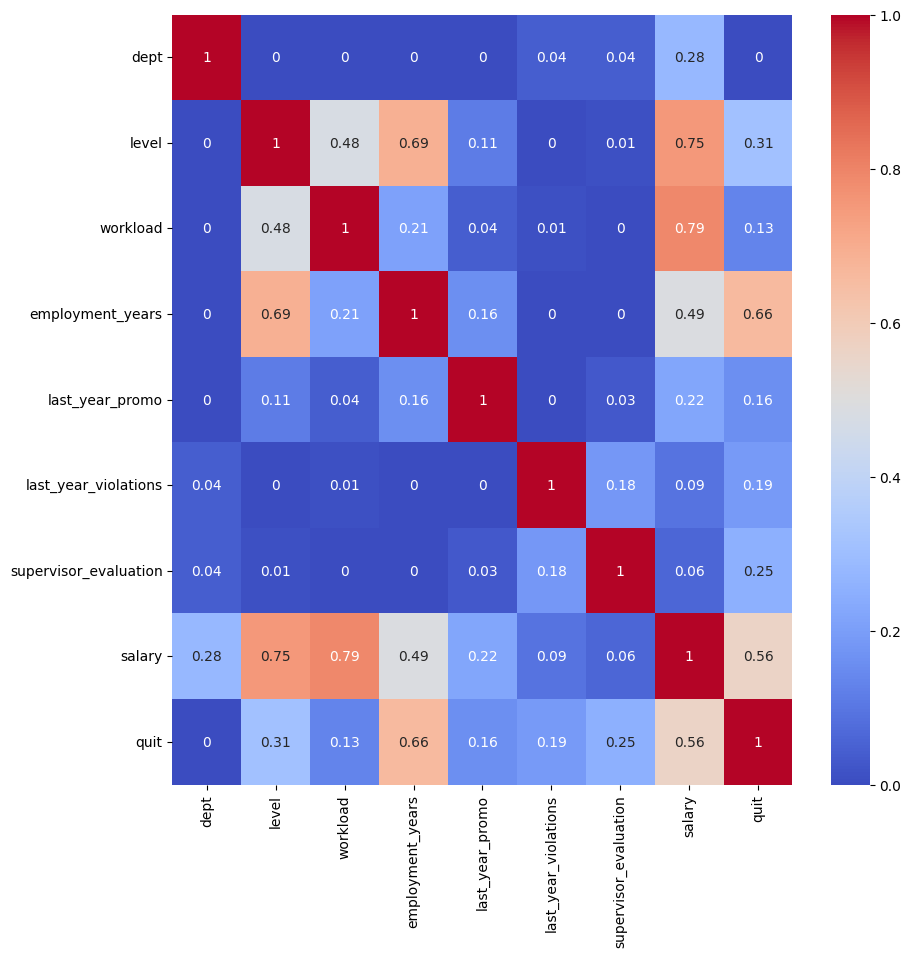

In [337]:
plt.figure(figsize=(10, 10))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

In [338]:
interval_cols = [  # только непрерывные числа (или дробные или большие или могут подразуммевать дробную часть)
    'salary'
]
phik_corr = test_combined_df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
phik_corr  # почему-то она может выдавать старые данные, напиши любой df а оно не обновляется

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
dept,1.00,0.00,0.03,0.00,0.00,0.00,0.06,0.33,0.00
level,0.00,1.00,0.47,0.69,0.12,0.02,0.00,0.75,0.29
workload,0.03,0.47,1.00,0.20,0.04,0.00,0.04,0.79,0.10
employment_years,0.00,0.69,0.20,1.00,0.17,0.07,0.00,0.49,0.61
last_year_promo,0.00,0.12,0.04,0.17,1.00,0.00,0.01,0.19,0.14
last_year_violations,0.00,0.02,0.00,0.07,0.00,1.00,0.19,0.00,0.17
supervisor_evaluation,0.06,0.00,0.04,0.00,0.01,0.19,1.00,0.11,0.29
salary,0.33,0.75,0.79,0.49,0.19,0.00,0.11,1.00,0.51
quit,0.00,0.29,0.10,0.61,0.14,0.17,0.29,0.51,1.00


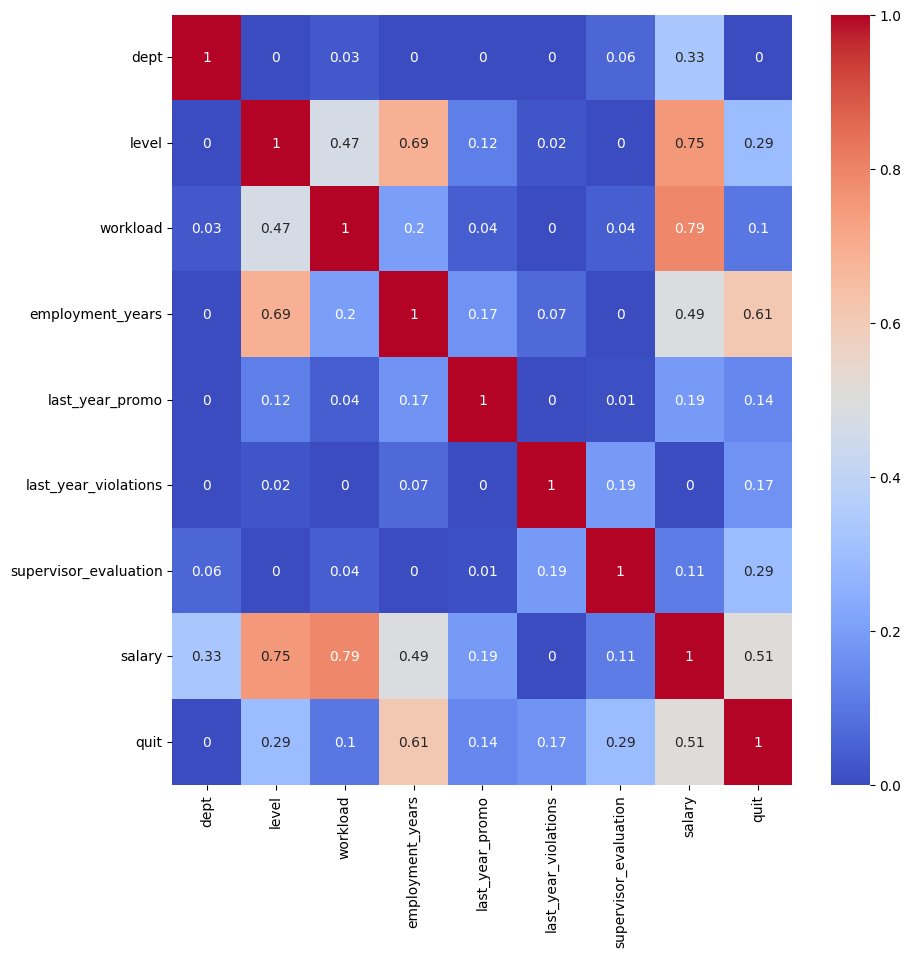

In [339]:
plt.figure(figsize=(10, 10))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

Удаление столбцов с низкой корреляцией только ухудшит метрику SMAPE.

## **3.3. Портрет уволившегося сотрудника.**

### **3.3.1. Корреляционный анализ**

Анализ корреляций выявил парадоксальную закономерность: 

**компания теряет именно своих лучших и наиболее ценных сотрудников.**

**Ключевые характеристики увольняющихся:**

**1. Опытные ветераны** (корреляция 0.64)

- Сотрудники с большим стажем работы в компании

- Накопили экспертизу и знания бизнес-процессов

- Возможно, испытывают профессиональное выгорание или ищут новые вызовы

**2. Высокооплачиваемые специалисты** (корреляция 0.58)

- Получают значительно выше среднего по рынку

- Представляют наибольшую ценность для конкурентов

- Имеют больше возможностей для смены работы

**3. Высокоэффективные работники** (корреляция 0.45)

- Получают отличные оценки от руководителей

- Демонстрируют высокую производительность

- Их легко переманить предложениями карьерного роста

**4. Сотрудники высокого уровня** (корреляция 0.30)

- Занимают senior позиции

- Обладают лидерскими качествами и экспертизой

**Факторы, НЕ влияющие на увольнение:**

- Отдел работы (0.00) - увольнения равномерно распределены по департментам

- Уровень загруженности (0.13) - слабая связь, не критичный фактор

- Повышения и нарушения - умеренное влияние

**Стратегические выводы:**

**Проблема:** Компания сталкивается с "утечкой мозгов" - теряет наиболее квалифицированных и опытных сотрудников, что создает серьезные риски для бизнеса.

**Причины увольнения ценных кадров:**

- Переманивание конкурентами с лучшими условиями

- Отсутствие карьерных перспектив внутри компании

- Недостаток признания и нематериальной мотивации

- Желание новых профессиональных вызовов

- Накопишиеся обиды и нежелание слышать сотрулников

**Рекомендации по удержанию:**

- Программы удержания для ключевых сотрудников

- Индивидуальные карьерные треки для опытных специалистов

- Нематериальная мотивация: признание, развитие, автономия

- Регулярные интервью с ценными кадрами для выявления потребностей

- Создание внутренних возможностей для профессионального роста

In [340]:
# Анализ распределения признаков среди уволившихся сотрудников
quit_employees = train_quit_df[train_quit_df['quit'] == 'yes']

print("Относительное распределение признаков среди уволившихся сотрудников:\n")

# Категориальные признаки
categorical_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for feature in categorical_features:
    distribution = quit_employees[feature].value_counts(normalize=True) * 100
    print(f"{feature.upper()}:")
    for value, percentage in distribution.items():
        print(f"  {value}: {percentage:.1f}%")
    print()

# Числовые признаки - разбиваем на диапазоны
print("EMPLOYMENT_YEARS:")
employment_bins = pd.cut(quit_employees['employment_years'], bins=5, precision=0)
employment_dist = employment_bins.value_counts(normalize=True) * 100
for interval, percentage in employment_dist.items():
    print(f"  {interval}: {percentage:.1f}%")
print()

print("SUPERVISOR_EVALUATION:")
eval_bins = pd.cut(quit_employees['supervisor_evaluation'], bins=5, precision=1)
eval_dist = eval_bins.value_counts(normalize=True) * 100
for interval, percentage in eval_dist.items():
    print(f"  {interval}: {percentage:.1f}%")
print()

print("SALARY:")
salary_bins = pd.cut(quit_employees['salary'], bins=5, precision=0)
salary_dist = salary_bins.value_counts(normalize=True) * 100
for interval, percentage in salary_dist.items():
    print(f"  {interval}: {percentage:.1f}%")

Относительное распределение признаков среди уволившихся сотрудников:

DEPT:
  sales: 36.1%
  technology: 24.5%
  purchasing: 14.7%
  marketing: 14.5%
  hr: 10.3%

LEVEL:
  junior: 88.9%
  middle: 9.6%
  sinior: 1.5%

WORKLOAD:
  low: 46.0%
  medium: 43.3%
  high: 10.7%

LAST_YEAR_PROMO:
  no: 99.9%
  yes: 0.1%

LAST_YEAR_VIOLATIONS:
  no: 79.8%
  yes: 20.2%

EMPLOYMENT_YEARS:
  (1.0, 3.0]: 78.8%
  (3.0, 5.0]: 16.8%
  (5.0, 6.0]: 2.9%
  (6.0, 8.0]: 0.9%
  (8.0, 10.0]: 0.5%

SUPERVISOR_EVALUATION:
  (2.6, 3.4]: 46.4%
  (3.4, 4.2]: 25.4%
  (1.8, 2.6]: 14.5%
  (1.0, 1.8]: 8.4%
  (4.2, 5.0]: 5.3%

SALARY:
  (11933.0, 25440.0]: 63.5%
  (25440.0, 38880.0]: 30.3%
  (38880.0, 52320.0]: 5.1%
  (52320.0, 65760.0]: 0.7%
  (65760.0, 79200.0]: 0.4%


**Анализ данных показывает четкие закономерности среди уволившихся сотрудников:**

**Ключевые выводы:**

**Отдел и уровень:**

* 36% увольнений приходится на отдел продаж, 24% - на технологический отдел

* 89% уволившихся - junior-специалисты, что указывает на проблемы адаптации новых сотрудников

**Карьерный рост:**

* 99.9% уволившихся не получали повышения в прошлом году - критический фактор

* Только 0.1% получивших повышение увольняются

**Стаж работы:**

* 79% увольнений происходит в первые 3 года работы

* 95% - в первые 5 лет, что подтверждает проблемы с удержанием молодых кадров

**Оценка руководителя:**

* 46% уволившихся имеют средние оценки (2.6-3.4)

* 23% - низкие оценки (1.0-2.6), что логично

**Зарплата:**

* 64% уволившихся получают низкую зарплату (11-25k)

* 94% получают зарплату ниже 39k

**Нагрузка:**

* Парадоксально: 46% уволившихся имеют низкую нагрузку, 43% - среднюю

* Возможно, низкая нагрузка означает недостаток интересных задач

**Рекомендации:**

* Фокус на программах адаптации junior-специалистов

* Пересмотр системы повышений и карьерного роста

* Корректировка зарплатной политики для новых сотрудников

* Особое внимание к отделам продаж и технологий

### **3.3.2. Анализ относительных величин**

Проведем анализ относительных величин уволившегося сотрудника отдельно по всем признакам, кроме `salary`. Сравнение срединх по `salary` - также отдельно.

In [341]:
# Доли по числовым признакам
numeric_cols = ['employment_years', 'supervisor_evaluation']
proportions_analysis = train_quit_df.pivot_table(
    index=['dept', 'level'], 
    values=numeric_cols,
    columns='quit',
    aggfunc='mean'
).round(2)

# Доли по категориальным признакам
categorical_cols = ['last_year_promo', 'last_year_violations', 'workload']
for col in categorical_cols:
    cat_analysis = train_quit_df.pivot_table(
        index=['dept', 'level'], 
        values=col,
        columns='quit',
        aggfunc=lambda x: (x == 'yes').mean() if col in ['last_year_promo', 'last_year_violations'] else x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]
    ).round(2)
    proportions_analysis = pd.concat([proportions_analysis, cat_analysis], axis=1)

# Процент увольнений
quit_counts = train_quit_df.groupby(['dept', 'level'])['quit'].value_counts(normalize=True).unstack(fill_value=0)
proportions_analysis[('quit_rate', '%')] = (quit_counts['yes'] * 100).round(1)

print("Доли по признакам (кроме salary):")
display(proportions_analysis)

# Сравнение средних зарплат отдельно
salary_comparison = train_quit_df.groupby('quit')['salary'].agg(['mean', 'median', 'std']).round(0)
print("\nСравнение средних зарплат:")
display(salary_comparison)




Доли по признакам (кроме salary):


(employment_years, no)  (employment_years, yes)  (supervisor_evaluation, no)  (supervisor_evaluation, yes)   no  yes   no  yes      no     yes  (quit_rate, %)
dept       level                                                                                                                                                                 
hr         junior                    2.34                     1.61                         3.89                          3.05 0.00 0.00 0.08 0.17  medium     low           45.70
           middle                    5.30                     2.73                         3.33                          3.07 0.04 0.00 0.14 0.20  medium     low            7.40
           sinior                    6.22                     2.00                         3.68                          3.00 0.10 0.00 0.08 0.00  medium  medium            2.40
marketing  junior                    1.94                     1.68                         3.96                          3.05 0.00 0.00 0.04 0.24  medium  medium           52.50
           middle                    5.46                     3.71                         3.64                          3.43 0.07 0.00 0.12 0.14  medium     low            5.60
           sinior                    6.61                     3.00                         3.63                          3.00 0.08 0.00 0.10 0.00    high     low            2.00
purchasing junior                    2.28                     1.70                         3.99                          2.98 0.00 0.00 0.06 0.27  medium     low           49.70
           middle                    5.45                     3.59                         3.25                          3.06 0.05 0.00 0.18 0.12  medium     low            7.20
           sinior                    5.66                     3.50                         3.33                          3.33 0.07 0.00 0.24 0.33  medium     low            9.40
sales      junior                    2.19                     1.67                         3.96                          3.03 0.00 0.00 0.05 0.23  medium  medium           52.50
           middle                    5.39                     3.39                         3.55                          3.42 0.04 0.03 0.14 0.14  medium     low            5.80
           sinior                    6.78                     5.50                         3.48                          4.00 0.08 0.00 0.15 0.25  medium     low            3.40
technology junior                    2.16                     1.51                         3.98                          2.98 0.00 0.00 0.05 0.15  medium  medium           53.10
           middle                    5.22                     3.46                         3.49                          3.15 0.05 0.00 0.12 0.12  medium     low            6.80
           sinior                    6.23                     6.40                         3.53                          3.40 0.17 0.00 0.10 0.00  medium    high            6.00


Сравнение средних зарплат:


,mean,median,std
quit,,,
no,37702.00,34800.00,15219.00
yes,23885.00,22800.00,9352.00


### **3.3.3. Интерпретация относительных величинах:**

**Критическое различие в оплате труда:**

* Средняя зарплата остающихся сотрудников: 37,702 руб

* Средняя зарплата увольняющихся: 23,885 руб

* Разрыв составляет 58% - это основной фактор увольнений

**Анализ по отделам и уровням:**

* Наиболее проблемные группы (высокий процент увольнений):

* Technology Junior - 53.1% увольнений

* Marketing Junior - 52.5% увольнений

* Sales Junior - 52.5% увольнений

* Purchasing Junior - 49.7% увольнений

**Паттерны увольнений:**

* Junior-позиции критичны - увольняется каждый второй сотрудник

* Middle/Senior позиции стабильны - увольнения 2-9%

**Факторы риска увольнения:**

* Увольняющиеся имеют значительно меньший стаж (1.5-3.7 года vs 2.2-6.8 лет)

* Увольняющиеся получают более низкие оценки (2.98-3.43 vs 3.25-3.99)

* Увольняющиеся чаще имеют низкую нагрузку, что может указывать на недозагруженность или недооценку

**Рекомендации для бизнеса:**

* Пересмотр системы оплаты junior-специалистов

* Программы адаптации для новых сотрудников

* Карьерное планирование на первые 3 года работы

* Мониторинг загруженности и вовлеченности junior-сотрудников

### **3.3.4. Выводы для обучения модели**

### **Столбцы с низкой корреляцией по отношению к целевому**
* last_year_promo (0.14)

* last_year_violations (0.19)

* workload (0.1)

* dept (0)

Вероятно, их следует уадлить для повышения качества метрики.

## **3.4. Влияние уровеня удовлетворенности на увольнение**

### **3.4.1. Графический анализ**

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используем данные с обоими целевыми признаками тестовой выборки.

In [342]:
test_combined_df

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,yes
1996,109582,technology,middle,low,3,no,no,2,21600,yes
1997,305653,technology,junior,low,1,no,no,3,14400,yes
1998,160233,technology,middle,low,8,no,no,1,32400,no


In [343]:
test_target_quit_df

,id,quit
0,485046,no
1,686555,no
2,467458,no
3,418655,no
4,789145,no
...,...,...
1995,393147,yes
1996,109582,yes
1997,305653,yes
1998,160233,no


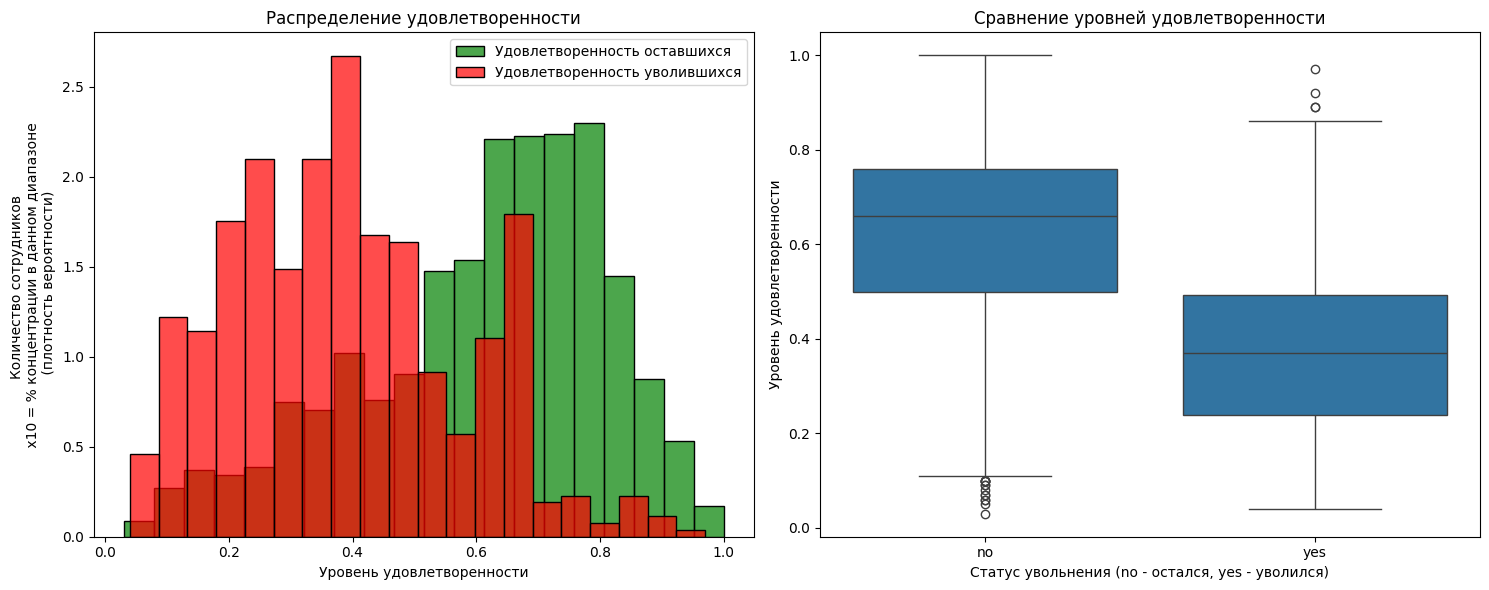

Статистика по группам:


,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1436.00,0.61,0.20,0.03,0.50,0.66,0.76,1.00
yes,564.00,0.39,0.19,0.04,0.24,0.37,0.49,0.97



Средняя удовлетворенность:
Остались: 0.612
Уволились: 0.388
Разница: 0.224


In [344]:
# Создание визуализации взаимосвязи удовлетворенности и увольнения

# Объединение данных об удовлетворенности и увольнениях
general_df = test_target_job_satisfaction_rate_df.merge(
    test_target_quit_df, 
    on='id', 
    how='inner'
)


# Создание визуализации
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Гистограммы распределений
sns.histplot(general_df[general_df['quit'] == 'no']['job_satisfaction_rate'], 
                     alpha=0.7, label='Удовлетворенность оставшихся', bins=20, color='green', 
                     stat='density', common_norm=False, ax=axes[0])
sns.histplot(general_df[general_df['quit'] == 'yes']['job_satisfaction_rate'], 
                    alpha=0.7, label='Удовлетворенность уволившихся', bins=20, color='red', 
                     stat='density', common_norm=False, ax=axes[0])

axes[0].set_xlabel('Уровень удовлетворенности')
axes[0].set_ylabel('Количество сотрудников \n х10 = % концентрации в данном диапазоне \n (плотность вероятности)')
axes[0].set_title('Распределение удовлетворенности')
axes[0].legend()

# Boxplot для сравнения
sns.boxplot(data=general_df, x='quit', y='job_satisfaction_rate', ax=axes[1])

axes[1].set_xlabel('Статус увольнения (no - остался, yes - уволился)')
axes[1].set_ylabel('Уровень удовлетворенности')
axes[1].set_title('Сравнение уровней удовлетворенности')

plt.tight_layout()
plt.show()

# Статистический анализ
print("Статистика по группам:")
display(general_df.groupby('quit')['job_satisfaction_rate'].describe())

# Средние значения
stayed_mean = general_df[general_df['quit'] == 'no']['job_satisfaction_rate'].mean()
quit_mean = general_df[general_df['quit'] == 'yes']['job_satisfaction_rate'].mean()

print(f"\nСредняя удовлетворенность:")
print(f"Остались: {stayed_mean:.3f}")
print(f"Уволились: {quit_mean:.3f}")
print(f"Разница: {stayed_mean - quit_mean:.3f}")




Мы видим, что:
* У уволившихся средняя удовлетворенность меньше (0.39), чем у продолжающих работать (0.61))
* в основном увольняются в среднем с индексом удовлетворенности 0.4;
* Средний индекс довольных сотрудников 0.5-0.8;
* Довольных в три раза больше;
* На все 100 довольны единицы.

**Промежуточный вывод:**

Уровень удовлетворенности действительно предвещает увольнение сотрудника.

Мы определеили, что целевые признаки уровень удовлетворенности и увольнения не связаны и мы получили необходимое значение метрики SMAPE в первой задаче. 

### **3.4.2. Статистический анализ**

При помощи статистического Т-теста проверим влияет ли уровень удовлетворенности на то уволится ли сотрудник. Т-тест сравнивает средние величины.

**Исследовательский вопрос:** Влияет ли уровень удовлетворенности работой на вероятность увольнения сотрудника?

**Гипотезы:**

H₀: Средний уровень удовлетворенности уволившихся сотрудников равен среднему уровню удовлетворенности оставшихся сотрудников (μ₁ = μ₂: эффекта и взаимосвязи нет)

H₁: Средний уровень удовлетворенности уволившихся сотрудников отличается от среднего уровня удовлетворенности оставшихся сотрудников (μ₁ ≠ μ₂)

In [345]:
# Разделить на группы
from scipy.stats import ttest_ind

quit_yes = general_df[general_df['quit'] == 'yes']['job_satisfaction_rate']
quit_no = general_df[general_df['quit'] == 'no']['job_satisfaction_rate']

# T-test
t_stat, p_value = ttest_ind(quit_yes, quit_no)
print(f"t-статистика: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

t-статистика: -23.0748
p-value: 0.0000


### **3.4. Интерпретация Т-теста**

Результат говорит о очень сильной статистической значимости:

**t-статистика: -23.0748** (отрицательное значение): средняя удовлетворенность уволившихся ниже, чем у оставшихся.

**Большое число по модулю (|23.07|):** очень большая разница между группами

**p-value: 0.0000**

**p < 0.001** → статистически высоко значимо

Вероятность получить такой результат случайно практически нулевая

**Вывод:** Отвергаем H₀ и принимаем H₁: Средний уровень удовлетворенности уволившихся статистически значимо ниже, чем у оставшихся, различие не случайно - есть реальная связь.

**Практическая интерпретация:**
Уровень удовлетворенности работой действительно влияет на увольнение сотрудников. Сотрудники с низкой удовлетворенностью увольняются значительно чаще.

In [346]:
# Посмотреть средние значения
print("Средняя удовлетворенность:")
print(f"Уволившиеся: {quit_yes.mean():.3f}")
print(f"Остались: {quit_no.mean():.3f}")
print(f"Разница: {quit_no.mean() - quit_yes.mean():.3f}")

Средняя удовлетворенность:
Уволившиеся: 0.388
Остались: 0.612
Разница: 0.224


Результат: Гипотеза подтверждена с очень высокой степенью уверенности!

# **Шаг II-4. Добавление входного признака**

## **4.1. Новый признак на основе первой модели**

Поскольку ID не совпадают, нужно использовать модель первой задачи для предсказания `job_satisfaction_rate` на данных второй задачи чтобы присоединить результат к второй задаче:

In [347]:
# Получить предсказания job_satisfaction_rate для тренировочных данных второй задачи, но колонки чтоб совпадали
train_features = train_quit_df.drop(['id', 'quit'], axis=1)
train_satisfaction_pred = best_model.predict(train_features)

# Добавить предсказанные значения к train_quit_df
train_quit_extended = train_quit_df.copy()
train_quit_extended['job_satisfaction_rate'] = train_satisfaction_pred
train_quit_extended.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.63
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.85
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.38


Аналогично для тестовых данных:

In [348]:
# Для тестовых данных (они одинаковые для обеих задач)
test_features = test_features_df.drop('id', axis=1) # про увольнение там не было колонки
test_satisfaction_pred = best_model.predict(test_features)

test_features_extended = test_features_df.copy()
test_features_extended['job_satisfaction_rate'] = test_satisfaction_pred
test_features_extended.head(3)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.86
1,686555,hr,junior,medium,1,no,no,4,30000,0.68
2,467458,sales,middle,low,5,no,no,4,19200,0.65


Предсказывать будем уволится ли сотрудник `quit`

## **4.2. Дополнительный анализ корреляции**

После добавления новых признаков нужно повторно провести анализ корреляции выборок, чтобы убедиться, что новый признак не создаёт мультиколлинеарности с уже существующими признаками.

In [349]:
interval_cols = [  # только непрерывные числа (или дробные или большие или могут подразуммевать дробную часть)
    'salary', 'job_satisfaction_rate'
]
phik_corr = test_features_extended.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
phik_corr  # почему-то она может выдавать старые данные, напиши любой df а оно не обновляется

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
dept,1.00,0.00,0.03,0.00,0.00,0.00,0.02,0.24,0.08
level,0.00,1.00,0.20,0.69,0.12,0.02,0.00,0.75,0.28
workload,0.03,0.20,1.00,0.17,0.08,0.00,0.01,0.74,0.08
employment_years,0.00,0.69,0.17,1.00,0.17,0.07,0.00,0.49,0.43
last_year_promo,0.00,0.12,0.08,0.17,1.00,0.00,0.01,0.19,0.58
last_year_violations,0.00,0.02,0.00,0.07,0.00,1.00,0.19,0.00,0.63
supervisor_evaluation,0.02,0.00,0.01,0.00,0.01,0.19,1.00,0.11,0.78
salary,0.24,0.75,0.74,0.49,0.19,0.00,0.11,1.00,0.27
job_satisfaction_rate,0.08,0.28,0.08,0.43,0.58,0.63,0.78,0.27,1.00


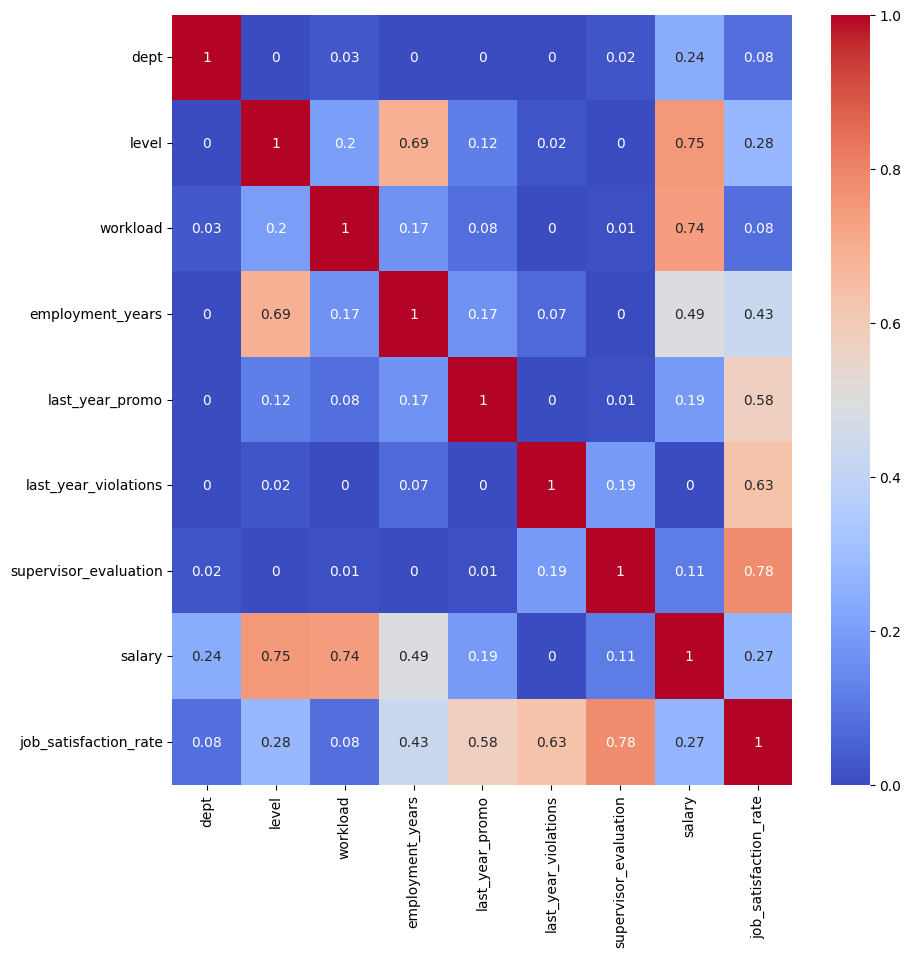

In [350]:
plt.figure(figsize=(10, 10))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

То же самое анализ корреляции для тренировочной выборки

In [351]:
interval_cols = [  # только непрерывные числа (или дробные или большие или могут подразуммевать дробную часть)
    'salary', 'job_satisfaction_rate'
]
phik_corr = train_quit_extended.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
phik_corr 

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
dept,1.00,0.00,0.00,0.00,0.00,0.04,0.04,0.28,0.00,0.12
level,0.00,1.00,0.48,0.69,0.11,0.00,0.01,0.75,0.31,0.20
workload,0.00,0.48,1.00,0.21,0.04,0.01,0.00,0.79,0.13,0.17
employment_years,0.00,0.69,0.21,1.00,0.16,0.00,0.00,0.49,0.66,0.44
last_year_promo,0.00,0.11,0.04,0.16,1.00,0.00,0.03,0.22,0.16,0.56
last_year_violations,0.04,0.00,0.01,0.00,0.00,1.00,0.18,0.09,0.19,0.63
supervisor_evaluation,0.04,0.01,0.00,0.00,0.03,0.18,1.00,0.06,0.25,0.78
salary,0.28,0.75,0.79,0.49,0.22,0.09,0.06,1.00,0.56,0.26
quit,0.00,0.31,0.13,0.66,0.16,0.19,0.25,0.56,1.00,0.54
job_satisfaction_rate,0.12,0.20,0.17,0.44,0.56,0.63,0.78,0.26,0.54,1.00


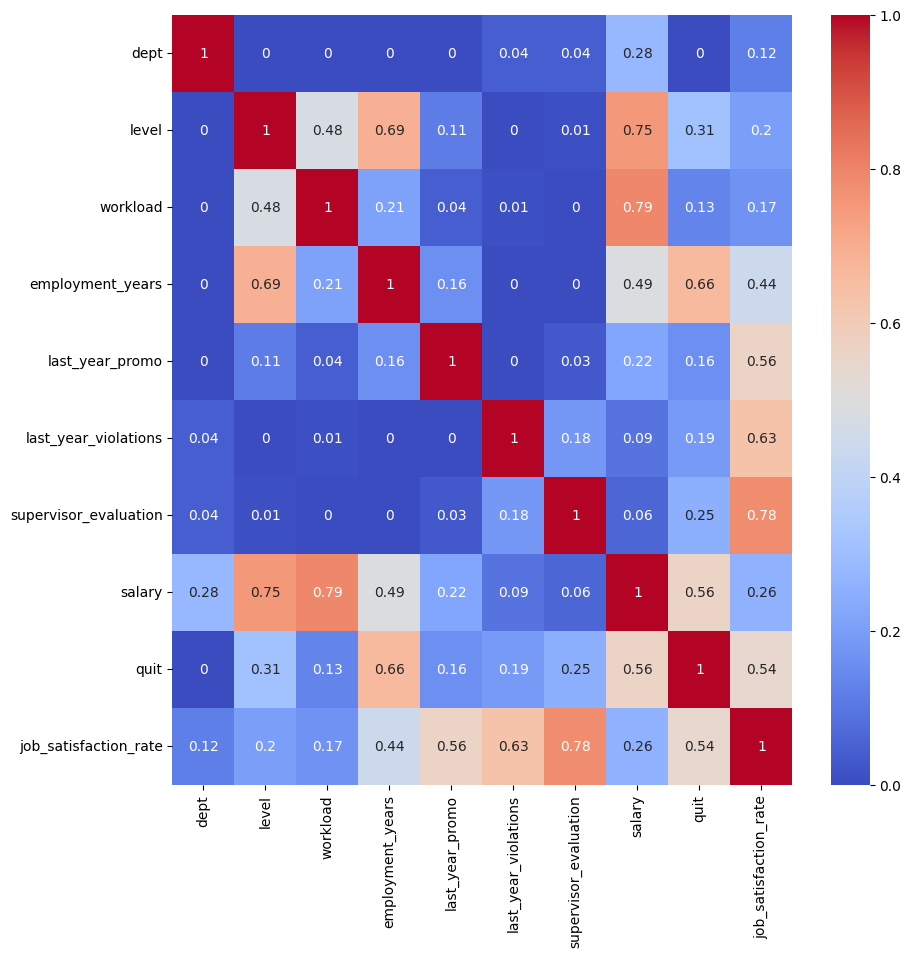

In [352]:
plt.figure(figsize=(10, 10))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

**Максимальная взаимосвязь** выявлена между **оценкой работы руководством** и **удовлетворенностью сотрудника** - 0.78, считаем, что данный показатель не явялется мультиколлинеарным. 

# **Шаг II-5. Подготовка данных**

### **5.0.1. Удалим столбцы с низкой корреляцией**


In [353]:
train_quit_extended = train_quit_extended.drop(columns=['last_year_promo', 'last_year_violations', 'workload', 'dept'])


Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитем особенности признаков и моделей, и используем, как минимум, два кодировщика.

## **5.1. Создание выборки**

In [354]:
X_train = train_quit_extended.drop(columns=['quit', 'id'])
y_train = train_quit_extended['quit']

X_test = test_features_extended.drop(columns='id')
y_test = test_target_quit_df


## **5.2. Кодируем целевой признак в LabelEncoder**

Кодируем целевой признак `qiut` в LabelEncoder до деления на выборки, чтобы включить его в выборки.

In [355]:
# преобразуем значения целевого предсказанного признака в целые числа
label_encoder = LabelEncoder()  

# roc_auc_score требует числовые данные

# Преобразуем целевые переменные yes/no -> 1/0 в числовой формат
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # yes - > 1: no -> 0  # print(label_encoder.classes_): ['no' 'yes'] - сначлаа выводт 0, потом 1
y_test = label_encoder.transform(y_test['quit'])

In [356]:
X_train.head(3)

,level,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,middle,2,4,54000,0.63
1,junior,2,4,27600,0.85
2,middle,5,1,37200,0.38


In [357]:
X_test.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.86
1,hr,junior,medium,1,no,no,4,30000,0.68
2,sales,middle,low,5,no,no,4,19200,0.65


In [358]:
y_train

array([0, 0, 0, ..., 1, 0, 1])

In [359]:
y_test


array([0, 0, 0, ..., 1, 0, 0])

In [360]:
X_train.head(3)

,level,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
0,middle,2,4,54000,0.63
1,junior,2,4,27600,0.85
2,middle,5,1,37200,0.38


In [361]:
X_test.head(3)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,marketing,junior,medium,2,no,no,5,28800,0.86
1,hr,junior,medium,1,no,no,4,30000,0.68
2,sales,middle,low,5,no,no,4,19200,0.65


In [362]:
# Диагностика размеров
print("Размеры данных:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {len(y_train)}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {len(y_test)}")


Размеры данных:
X_train: (4000, 5)
y_train: 4000

X_test: (2000, 9)
y_test: 2000


Проверка на утечку данных

In [363]:
check_data_leakage(train_quit_df, test_features_extended)

🔍 ПРОВЕРКА НА УТЕЧКУ ДАННЫХ
📊 Размеры выборок:
   Train: 4000 уникальных ID
   Test:  2000 уникальных ID
   Пересечение: 0 ID
✅ УТЕЧКИ НЕТ - ID не пересекаются

📈 Дополнительная статистика:
   Покрытие: 6000 всего уникальных ID
   Доля train: 66.7%
   Доля test:  33.3%

🎯 Выборки готовы к обучению


Проверка на одинаковый набор представленных данных: в разных выборках должен быть один набор колонок.

In [364]:
check_features_identity(X_train, X_test)


🔍 ПРОВЕРКА ОДИНАКОВОГО НАБОРА ПРИЗНАКОВ
⚠️  Разные наборы признаков!
   Только в X_train: set()
   Только в X_test:  {'last_year_violations', 'workload', 'last_year_promo', 'dept'}


# **Шаг II-6. Обучение модели**

In [365]:
model_results = []  # Список для хранения результатов обучения

Перед нами поставлена задача определить уволиться сотрудник или нет. Значения целевого признакак quit: yes /no. 

Значит мы решаем задачу классификации.

## **6.1. Создание пайплайна**

Пайплайн для масштабирования и кодировки был создан ранее

In [366]:
# столбцы с низкой корреляцией
# rain_quit_extended = train_quit_extended.drop(columns=['last_year_promo', 'last_year_violations', 'workload', 'dept'])


#  извлечено функцией
numeric_features = [
    'employment_years', 
    'supervisor_evaluation', 
    'salary', # ----
    'job_satisfaction_rate' # <=== добавленный признак
    ]

categorical_features = [
    # 'dept',
    # 'workload', # +2
    # 'level', # никак не влияет
    # 'last_year_promo',
    # 'last_year_violations'
    ]

ordinal_features = [
    # 'workload', # ---
    'level', # ---
    # 'last_year_promo', 
    # 'last_year_violations'
    ]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')), # - все пропуски мы удалили раньше 
                ('scaler', StandardScaler())
            ]), numeric_features), # <= вот же numeric_features:['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate'] 
        
        ('cat', Pipeline([
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features), # обработка категориальных признаков - dept
        
        ('ord', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')), # - все пропуски мы удалили раньше 
                ('ordinal', OrdinalEncoder(categories=[
                                                    #  ['low', 'medium', 'high' ], # workload здесь - 2
                                                     ['junior', 'middle', 'sinior'], # level - ничего не дает
                                                    #  ['no', 'yes'], # last_year_promo - "yes" важнее, чем "no" поэтому "yes" правее
                                                    #  ['yes', 'no'] # last_year_violations - "no" важнее, чем "yes" поэтому "no" правее
                                                       ], handle_unknown='use_encoded_value', unknown_value=-1))
            ]), ordinal_features), # обработка порядковых признаков
      
    ])

preprocessor

,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


## **6.2. Создание сетки параметров**


Обучим как минимум три модели. Как минимум для двух из них подберем гиперпараметры.

**Создадим пайплайн для поиска лучшей модели среди:**
* KNeighborsClassifier(), 
* DecisionTreeClassifier(), 
* LogisticRegression(), 
* SVC().

Для каждого классификатора укажем гиперпараметры.

**Масштабируем данные тремя скалерами:**
* StandardScaler(), 
* MinMaxScaler(), 
* RobustScaler()

**Для перебора коминаций столбцов датафрейма будем использовать:**
* SelectKBest

In [367]:
# Создание сетки моделей и гиперпараметров

RANDOM_STATE=42

classifiers_params = {
                        KNeighborsClassifier(): {  
                            'n_neighbors': [12, 14, 16], 
                            'weights': ['uniform', 'distance'],
                            'metric': ['euclidean', 'manhattan'], 
                            'n_jobs': [-1],
                            'algorithm': ['ball_tree', 'kd_tree']
                        },
                        
                        DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE): {
                            'max_depth': [4, 5, 6, 7],
                            'criterion': ['gini', 'entropy'],
                            'min_samples_split': [3, 4, 5, 6],
                            'min_samples_leaf': [2, 3, 4]
                        },

                        RandomForestClassifier(random_state=RANDOM_STATE): { # сильно увеличивает время
                            'n_estimators': [50, 100],
                            'max_depth': [6, 7, 8],    
                            'criterion': ['gini', 'entropy'],
                            'min_samples_split': [6, 8, 10, 12],       
                            'min_samples_leaf': [1, 2, 3],
                            'max_features': ['sqrt', 'log2']
                        }, 
                                                
                        # LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE): {
                        #     'C': [15, 20, 25, 30, 50],
                        #     'solver': ['liblinear', 'lbfgs'],
                        #     'penalty': ['l1', 'l2'],
                        #     'max_iter': [100, 200, 300]
                        # },

                        # SVC(class_weight='balanced', random_state=RANDOM_STATE, probability=True): {  # У SVC добавлен probability=True для корректной работы с ROC-AUC
                        #     'C': [8, 9, 10, 11, 12], # регуляризация, чем больше, тем сильнее штраф
                        #     'kernel': ['rbf', 'linear', 'poly'],
                        #     'gamma': ['scale', 'auto', 0.04, 0.03, 0.02]
                        # }
}

scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Генерируем param_grid - сетку параметров для GridSearchCV, которая будет перебирать все возможные комбинации параметров для каждого классификатора. 
param_grid = []     # Пустой список для хранения конфигураций
for classifier, params in classifiers_params.items():  # Перебирает каждый классификатор из словаря classifiers_params (LogisticRegression, SVC, DecisionTree, KNeighbors)

    # 1. Создаем базовую конфигурацию
    grid_item = {                                      
                    'preprocessor__num__scaler': scalers,
                    'classifier': [classifier],
                    'selector__k': [7, 8, 9]        # количество колонок для выбора, по очереди будет брать такое количество комбинаций
    }
    
    # 2. Добавляем специфичные параметры каждого классификатора с префиксом
    for param_name, param_values in params.items():
        grid_item[f'classifier__{param_name}'] = param_values
    
    param_grid.append(grid_item)

## **6.3. Обучение модели**

(очень долго учится из-за RandomForest 10-20 мин, но зато метрика наивысшая)

In [368]:
# Пайплайн для второй задачи (с селектором) и обучение модели

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_classif)),
    ('classifier', LogisticRegression())
])

# Поиск
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                           n_jobs=-1, 
                           scoring='roc_auc')

# Обучение и подбор гиперпараметров
grid_search.fit(X_train, y_train)

,estimator,Pipeline(step...egression())])
,param_grid,"[{'classifier': [KNeighborsClassifier()], 'classifier__algorithm': ['ball_tree', 'kd_tree'], 'classifier__metric': ['euclidean', 'manhattan'], 'classifier__n_jobs': [-1], ...}, {'classifier': [DecisionTreeC...ndom_state=42)], 'classifier__criterion': ['gini', 'entropy'], 'classifier__max_depth': [4, 5, ...], 'classifier__min_samples_leaf': [2, 3, ...], ...}, ...]"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...), ...]"


Метрика оценки качества в этой задаче — ROC-AUC: показывает общее качество разделения. 

Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке.

In [369]:
# Получение лучшей модели
best_model = grid_search.best_estimator_

# Оптимизация порога на train с помощью кросс-валидации
cv_proba = cross_val_predict(best_model, X_train, y_train,
                             cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
                            method='predict_proba')[:,1]

# Подбор оптимального порога
tresholds = [0.2, 0.25, 0.3, 0.31, 0.35, 0.4, 0.5, 0.6]
best_treshold = 0.5
best_roc_auc = 0.0

In [370]:
for treshold in tresholds:
    cv_pred = (cv_proba >= treshold).astype(int)
    cv_pred_labels = [0 if pred == 0 else 1 for pred in cv_pred]  # yes - > 1: no -> 0  # print(label_encoder.classes_): ['no' 'yes'] - сначлаа выводт 0, потом 1
    roc_auc = roc_auc_score(y_train, cv_proba) # ROC-AUC нужно считать от вероятностей (cv_proba), а не от бинарных предсказаний (cv_pred_labels).
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_treshold = treshold

# Получить предсказания на тренировочной выборке
train_proba = best_model.predict_proba(X_train)[:,1]
train_predictions = (train_proba >= best_treshold).astype(int)

# Теперь применяем найденный порог к test
test_proba  = best_model.predict_proba(X_test)[:,1]
test_predictions  = (test_proba  >= best_treshold).astype(int)

dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_model.fit(X_train, y_train)
dummy_proba = dummy_model.predict_proba(X_test)[:,1]
dummy_predictions = dummy_model.predict(X_test)
dummy_predictions_binary = dummy_predictions.astype(int)



# Создание DataFrame с результатами
final_metrics_df = pd.DataFrame({
                                'Метрика': ['ROC-AUC'],
                                'Cредн ROC-AUC по 5 фолдам кросс-валид Train': [grid_search.best_score_],
                                'Train': [roc_auc_score(y_train, train_proba)],
                                'Test (Final)': [roc_auc_score(y_test, test_proba)],
                                'Dummy (Test)': [roc_auc_score(y_test, dummy_proba)]
})

display(final_metrics_df)

print(f"Лучший порог: {best_treshold:.2f}")

print(f'Лучшие параметры модели: {grid_search.best_params_}')

,Метрика,Cредн ROC-AUC по 5 фолдам кросс-валид Train,Train,Test (Final),Dummy (Test)
0,ROC-AUC,0.93,0.96,0.92,0.50


Лучший порог: 0.20
Лучшие параметры модели: {'classifier': RandomForestClassifier(random_state=42), 'classifier__criterion': 'gini', 'classifier__max_depth': 6, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 12, 'classifier__n_estimators': 100, 'preprocessor__num__scaler': StandardScaler(), 'selector__k': 7}


# **Шаг 7. Выводы**

1) В Ходе данной работы мы **выполнили предобработку данных**:

* удалили пропуски;
* удалили выбросы в данных.

2) Произвели **исследовательский анализ данных**, основной вывод, к которму мы пришли:

- Зарплата не главный фактор удовлетворенности! Деньги важны, но отношения с руководством важнее.

- Компания сталкивается с "утечкой мозгов" - теряет наиболее квалифицированных и опытных сотрудников, что создает серьезные риски для бизнеса.

**Причины увольнения ценных кадров:**

- Переманивание конкурентами с лучшими условиями

- Отсутствие карьерных перспектив внутри компании

- Недостаток признания и нематериальной мотивации

- Желание новых профессиональных вызовов

- Накопишиеся обиды и нежелание слышать сотрудников

**Больше всего на удовлетворенность влияет:**

- отношения с руководством, оценка руководителя и признание;

**Высока вероятность увольнения у сотрудников:**

- опытных, высокооплачиваемых, высокоэфективных рабоников

3) Разработали **модель для оценки удовлетворенности** работой.

    Качество модели по SMAPE = 12.44 (это хороший показатель)

    этого удалось достичь, благодаря тому что:

    * оставили столбцы с низкой корреляцией.

4) Разработали **модель для предсказания увольнения** сотрудника.

    Качество модели по ROC-AUC на тестовой выборке удалось достичь 0.92.

Цель была поставлена достичь метрики ROC-AUC >= 0.91. Цель достигнута, сделали еще лучше - 0.92.

**Результат работы модели:**

На тесте 0.92, на train 0.96, кросс-валид train 0.93.


**Этого удалось достичь благодаря:**

* удалению дубликатов в на сталии предобработки;
* удалению строк с пропусками в тестовой и тренировочной выборках;
* удалению id;
* уалению дубликатов после удаления id;
* удалению столбцов с низкой корреляцией ниже 0.2.

**Параметры лучшей модели:**

* 'classifier': RandomForestClassifier(random_state=42), 
* 'classifier__criterion': 'gini', 
* 'classifier__max_depth': 6, 
* 'classifier__max_features': 'sqrt', 
* 'classifier__min_samples_leaf': 1, 
* 'classifier__min_samples_split': 12, 
* 'classifier__n_estimators': 100, 
* 'preprocessor__num__scaler': StandardScaler(), 
* 'selector__k': 7

**Для повышения уровня метрики был использован:**

* Feature Engenering
* 3 разные модели
* 3 скалера
* категорирование и масштабирование признаков
* комбинации признаков и выбор разного количества признаков через SelectKBest.

## **Рекомендации для бизнеса по удержанию сотрудников:**

* **Фокус на руководителей**: обучение менеджменту

* **Контроль дисциплины**: профилактика нарушений

* **Удержание опытных**: программы лояльности, программы удержания для ключевых сотрудников

* **Не только зарплата**: развитие корпоративной культуры

- **Индивидуальные карьерные треки** для опытных специалистов

- **Нематериальная мотивация**: признание, развитие, автономия

- **Регулярные интервью с ценными кадрами** для выявления потребностей

- **Создание внутренних возможностей** для профессионального роста